In [2]:
!pip install contractions
!pip install emoji --upgrade
!pip install transformers
!pip install germansentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 8.1 MB/s eta 0:00:00


In [3]:
import os
import psutil

# Function to get system information
def get_system_info():
    return {
        'Processor': os.popen("cat /proc/cpuinfo | grep 'model name' | uniq").read().strip(),
        'RAM': round(psutil.virtual_memory().total / (1024 ** 3), 2),  # in GB
        'Number of Cores': psutil.cpu_count(logical=False),
        'Logical CPUs': psutil.cpu_count(logical=True)
    }

# Get system information
system_info = get_system_info()

# Display system information
print("System Information:")
print("Processor:", system_info['Processor'])
print("RAM:", system_info['RAM'], "GB")
print("Number of Cores:", system_info['Number of Cores'])
print("Logical CPUs:", system_info['Logical CPUs'])


System Information:
Processor: model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
RAM: 12.67 GB
Number of Cores: 1
Logical CPUs: 2


# **Import Libraries Used in the Entire Code**

In [3]:
import re
import pickle
import sklearn
import pandas as pd
import numpy as np
import holoviews as hv
import nltk
from bokeh.io import output_notebook
output_notebook()
import os
#from hvplot import pandas
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sb


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from germansentiment import SentimentModel
from transformers import pipeline

# **Cleaning/ Pre-processing (remove unwanted characters,tokenize,lemmetize, remove stopwords)**

In [5]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the lemmatizer and stopwords for German
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("german"))

def clean_text(text, for_embedding=False):
    """
    - Remove any HTML tags (< /br> often found).
    - Keep only ASCII + European Chars and whitespace, no digits.
    - Remove single letter chars.
    - Convert all whitespaces (tabs etc.) to a single whitespace.
    - Remove URLs.
    - If for_embedding (True):
        - All lowercase.
        - Remove punctuation.
        - No stopwords removal and no lemmatization.
    - If not for_embedding (False):
        - Apply lemmatization.
        - Convert to lowercase.
        - Remove stopwords and punctuation.
    """
    RE_WSPACE = re.compile(r"\s+")
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_URLS = re.compile(r"http[s]?://\S+|www\.\S+")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]")
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b")
    RE_RETWEET = re.compile(r"RT\s+")

    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]")
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b")

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_URLS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)
    text = re.sub(RE_RETWEET, "", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # No lemmatization, lowering, stopwords removal, and punctuation removal for embedding
        words_filtered = word_tokens
    else:
        words_filtered = [
            lemmatizer.lemmatize(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **October-December 2022 (Time Frame 3 ) dataset**


In [7]:
# Define directory path
dir_path = '/content/drive/MyDrive/Data Set/2022_Tweets/'

# Initialize empty list to store data
data_list = []
df_combined = pd.DataFrame()

# Loop over all files in directory
for filename in os.listdir(dir_path):
    if filename.endswith('.json'):
        # Read JSON file
        dff = pd.read_json(os.path.join(dir_path, filename))
        df_text = dff[['text', 'created_at']]

        # Apply text cleaning
        df_text['text_cleaned'] = df_text['text'].apply(clean_text)

        # Concatenate cleaned text to the DataFrame
        df_combined = pd.concat([df_combined, df_text], ignore_index=True)

df_combined.rename(columns={0: 'text'}, inplace=True)
df_combined

<ipython-input-7-fc4ab4f0f08e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['text_cleaned'] = df_text['text'].apply(clean_text)


,text,created_at,text_cleaned
0,souverän bei Illner: Robert #Habeck\n\nzu viel...,2022-11-22 00:22:15,souverän illner robert habeck nzu vielen frage...
1,Eine gute Idee aus FRANKREICH \n-- aber bei so...,2022-11-22 03:51:56,gute idee frankreich soviel atomkratwerks schr...
2,Ukraine aktuell 22.11.22 #AKW #Cherson #Kiew ...,2022-11-22 11:46:05,ukraine aktuell akw cherson kiew putin russlan...
3,Ukraine aktuell 22.11.22 #AKW #Cherson #Kiew ...,2022-11-22 11:38:10,ukraine aktuell akw cherson kiew putin russlan...
4,Ukraine aktuell 22.11.22 #AKW #Cherson #GTSOU...,2022-11-22 15:44:45,ukraine aktuell akw cherson gtsou kiew klitsch...
...,...,...,...
660,Ich verlassen diesen Ort und ziehe zu #Mastodo...,2022-11-21 11:40:32,verlassen ort ziehe mastodonsocial genauer umw...
661,Die Ergebnisse der Regierung Merkel sowie der ...,2022-11-21 13:37:40,ergebnisse regierung merkel sowie ampelkoaliti...
662,Soviel zum Weiterbetrieb der hochsicheren und ...,2022-11-21 19:11:27,soviel weiterbetrieb hochsicheren modernen akw...
663,Liebe #Bundesregierung @GrueneBundestag @spdde...,2022-12-05 13:49:23,liebe bundesregierung gruenebundestag spdde fd...


In [8]:
word_length_list =[]
for item in df_combined['text_cleaned']:
  words = item.split()
  word_length_list.append(len(words))
df_combined['Lenght of cleaned_text'] = word_length_list
df_combined

,text,created_at,text_cleaned,Lenght of cleaned_text
0,souverän bei Illner: Robert #Habeck\n\nzu viel...,2022-11-22 00:22:15,souverän illner robert habeck nzu vielen frage...,24
1,Eine gute Idee aus FRANKREICH \n-- aber bei so...,2022-11-22 03:51:56,gute idee frankreich soviel atomkratwerks schr...,26
2,Ukraine aktuell 22.11.22 #AKW #Cherson #Kiew ...,2022-11-22 11:46:05,ukraine aktuell akw cherson kiew putin russlan...,10
3,Ukraine aktuell 22.11.22 #AKW #Cherson #Kiew ...,2022-11-22 11:38:10,ukraine aktuell akw cherson kiew putin russlan...,10
4,Ukraine aktuell 22.11.22 #AKW #Cherson #GTSOU...,2022-11-22 15:44:45,ukraine aktuell akw cherson gtsou kiew klitsch...,12
...,...,...,...,...
660,Ich verlassen diesen Ort und ziehe zu #Mastodo...,2022-11-21 11:40:32,verlassen ort ziehe mastodonsocial genauer umw...,12
661,Die Ergebnisse der Regierung Merkel sowie der ...,2022-11-21 13:37:40,ergebnisse regierung merkel sowie ampelkoaliti...,14
662,Soviel zum Weiterbetrieb der hochsicheren und ...,2022-11-21 19:11:27,soviel weiterbetrieb hochsicheren modernen akw...,13
663,Liebe #Bundesregierung @GrueneBundestag @spdde...,2022-12-05 13:49:23,liebe bundesregierung gruenebundestag spdde fd...,25


In [9]:
df_combined['Lenght of cleaned_text'].mean()

18.30827067669173

# **October-December 2022 (Time Frame 3) Bert Results**

In [9]:
model = SentimentModel()

texts = df_combined['text_cleaned'][0:2000]

result1 = model.predict_sentiment(texts)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [10]:
df_final = df_combined
df_final['result_bert'] = result1
df_final

,text,created_at,text_cleaned,Lenght of cleaned_text,result_bert
0,souverän bei Illner: Robert #Habeck\n\nzu viel...,2022-11-22 00:22:15,souverän illner robert habeck nzu vielen frage...,24,neutral
1,Eine gute Idee aus FRANKREICH \n-- aber bei so...,2022-11-22 03:51:56,gute idee frankreich soviel atomkratwerks schr...,26,negative
2,Ukraine aktuell 22.11.22 #AKW #Cherson #Kiew ...,2022-11-22 11:46:05,ukraine aktuell akw cherson kiew putin russlan...,10,negative
3,Ukraine aktuell 22.11.22 #AKW #Cherson #Kiew ...,2022-11-22 11:38:10,ukraine aktuell akw cherson kiew putin russlan...,10,negative
4,Ukraine aktuell 22.11.22 #AKW #Cherson #GTSOU...,2022-11-22 15:44:45,ukraine aktuell akw cherson gtsou kiew klitsch...,12,negative
...,...,...,...,...,...
660,Ich verlassen diesen Ort und ziehe zu #Mastodo...,2022-11-21 11:40:32,verlassen ort ziehe mastodonsocial genauer umw...,12,neutral
661,Die Ergebnisse der Regierung Merkel sowie der ...,2022-11-21 13:37:40,ergebnisse regierung merkel sowie ampelkoaliti...,14,neutral
662,Soviel zum Weiterbetrieb der hochsicheren und ...,2022-11-21 19:11:27,soviel weiterbetrieb hochsicheren modernen akw...,13,neutral
663,Liebe #Bundesregierung @GrueneBundestag @spdde...,2022-12-05 13:49:23,liebe bundesregierung gruenebundestag spdde fd...,25,negative


# **October-December 2022 (Time Frame 3) xlm-Roberta Results**

In [11]:
model_path = "citizenlab/twitter-xlm-roberta-base-sentiment-finetunned"

sentiment_classifier = pipeline("text-classification", model=model_path, tokenizer=model_path)
result1 =[]
for l in df_combined['text_cleaned'].iloc[0:2000]:
  result1.append(sentiment_classifier(l))

result1

config.json:   0%|          | 0.00/992 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

[[{'label': 'Neutral', 'score': 0.9917952418327332}],
 [{'label': 'Positive', 'score': 0.9834936857223511}],
 [{'label': 'Neutral', 'score': 0.9851118922233582}],
 [{'label': 'Neutral', 'score': 0.9851118922233582}],
 [{'label': 'Neutral', 'score': 0.9862603545188904}],
 [{'label': 'Neutral', 'score': 0.9858371019363403}],
 [{'label': 'Neutral', 'score': 0.9851118922233582}],
 [{'label': 'Neutral', 'score': 0.9888949394226074}],
 [{'label': 'Neutral', 'score': 0.9893395304679871}],
 [{'label': 'Neutral', 'score': 0.9888237118721008}],
 [{'label': 'Neutral', 'score': 0.9831106662750244}],
 [{'label': 'Neutral', 'score': 0.8996888399124146}],
 [{'label': 'Neutral', 'score': 0.9863629937171936}],
 [{'label': 'Negative', 'score': 0.7276515364646912}],
 [{'label': 'Neutral', 'score': 0.9905964136123657}],
 [{'label': 'Neutral', 'score': 0.9871269464492798}],
 [{'label': 'Neutral', 'score': 0.9892974495887756}],
 [{'label': 'Negative', 'score': 0.6856460571289062}],
 [{'label': 'Neutral', 's

In [12]:
labels_sent = [d['label'] for lst2 in result1 for d in lst2]
df_senti_model=pd.DataFrame(labels_sent)
#df_senti_model[0:]
df_senti_model = df_senti_model[0].str.lower()
df_senti_model

0       neutral
1      positive
2       neutral
3       neutral
4       neutral
         ...   
660     neutral
661     neutral
662     neutral
663     neutral
664     neutral
Name: 0, Length: 665, dtype: object

In [13]:
df_final = df_combined.iloc[0:2000]
df_final['result_roberta'] =df_senti_model
df_final

<ipython-input-13-456ef377d11d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['result_roberta'] =df_senti_model


,text,created_at,text_cleaned,Lenght of cleaned_text,result_bert,result_roberta
0,souverän bei Illner: Robert #Habeck\n\nzu viel...,2022-11-22 00:22:15,souverän illner robert habeck nzu vielen frage...,24,neutral,neutral
1,Eine gute Idee aus FRANKREICH \n-- aber bei so...,2022-11-22 03:51:56,gute idee frankreich soviel atomkratwerks schr...,26,negative,positive
2,Ukraine aktuell 22.11.22 #AKW #Cherson #Kiew ...,2022-11-22 11:46:05,ukraine aktuell akw cherson kiew putin russlan...,10,negative,neutral
3,Ukraine aktuell 22.11.22 #AKW #Cherson #Kiew ...,2022-11-22 11:38:10,ukraine aktuell akw cherson kiew putin russlan...,10,negative,neutral
4,Ukraine aktuell 22.11.22 #AKW #Cherson #GTSOU...,2022-11-22 15:44:45,ukraine aktuell akw cherson gtsou kiew klitsch...,12,negative,neutral
...,...,...,...,...,...,...
660,Ich verlassen diesen Ort und ziehe zu #Mastodo...,2022-11-21 11:40:32,verlassen ort ziehe mastodonsocial genauer umw...,12,neutral,neutral
661,Die Ergebnisse der Regierung Merkel sowie der ...,2022-11-21 13:37:40,ergebnisse regierung merkel sowie ampelkoaliti...,14,neutral,neutral
662,Soviel zum Weiterbetrieb der hochsicheren und ...,2022-11-21 19:11:27,soviel weiterbetrieb hochsicheren modernen akw...,13,neutral,neutral
663,Liebe #Bundesregierung @GrueneBundestag @spdde...,2022-12-05 13:49:23,liebe bundesregierung gruenebundestag spdde fd...,25,negative,neutral


In [14]:
df_final['created_at'] = pd.to_datetime(df_final['created_at'])

# Extract just the date portion
df_final['created_at'] = pd.to_datetime(df_final['created_at']).dt.date

df_final['year_month'] = pd.to_datetime(df_final['created_at']).dt.strftime('%Y-%m')
df_final

<ipython-input-14-73636559dcf6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['created_at'] = pd.to_datetime(df_final['created_at'])
<ipython-input-14-73636559dcf6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['created_at'] = pd.to_datetime(df_final['created_at']).dt.date
<ipython-input-14-73636559dcf6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,text,created_at,text_cleaned,Lenght of cleaned_text,result_bert,result_roberta,year_month
0,souverän bei Illner: Robert #Habeck\n\nzu viel...,2022-11-22,souverän illner robert habeck nzu vielen frage...,24,neutral,neutral,2022-11
1,Eine gute Idee aus FRANKREICH \n-- aber bei so...,2022-11-22,gute idee frankreich soviel atomkratwerks schr...,26,negative,positive,2022-11
2,Ukraine aktuell 22.11.22 #AKW #Cherson #Kiew ...,2022-11-22,ukraine aktuell akw cherson kiew putin russlan...,10,negative,neutral,2022-11
3,Ukraine aktuell 22.11.22 #AKW #Cherson #Kiew ...,2022-11-22,ukraine aktuell akw cherson kiew putin russlan...,10,negative,neutral,2022-11
4,Ukraine aktuell 22.11.22 #AKW #Cherson #GTSOU...,2022-11-22,ukraine aktuell akw cherson gtsou kiew klitsch...,12,negative,neutral,2022-11
...,...,...,...,...,...,...,...
660,Ich verlassen diesen Ort und ziehe zu #Mastodo...,2022-11-21,verlassen ort ziehe mastodonsocial genauer umw...,12,neutral,neutral,2022-11
661,Die Ergebnisse der Regierung Merkel sowie der ...,2022-11-21,ergebnisse regierung merkel sowie ampelkoaliti...,14,neutral,neutral,2022-11
662,Soviel zum Weiterbetrieb der hochsicheren und ...,2022-11-21,soviel weiterbetrieb hochsicheren modernen akw...,13,neutral,neutral,2022-11
663,Liebe #Bundesregierung @GrueneBundestag @spdde...,2022-12-05,liebe bundesregierung gruenebundestag spdde fd...,25,negative,neutral,2022-12


In [15]:
def barPerc(df,xVar,ax):
    '''
    barPerc(): Add percentage for hues to bar plots
    args:
        df: pandas dataframe
        xVar: (string) X variable
        ax: Axes object (for Seaborn Countplot/Bar plot or
                         pandas bar plot)
    '''
    # 1. how many X categories
    ##   check for NaN and remove
    numX=len([x for x in df[xVar].unique() if x==x])

    # 2. The bars are created in hue order, organize them
    bars = ax.patches
    ## 2a. For each X variable
    for ind in range(numX):
        ## 2b. Get every hue bar
        ##     ex. 8 X categories, 4 hues =>
        ##    [0, 8, 16, 24] are hue bars for 1st X category
        hueBars=bars[ind:][::numX]
        ## 2c. Get the total height (for percentages)
        total = sum([x.get_height() for x in hueBars])

        # 3. Print the percentage on the bars
        for bar in hueBars:
            ax.text(bar.get_x() + bar.get_width()/2.,
                    bar.get_height(),
                    f'{bar.get_height()/total:.0%}',
                    ha="center",va="bottom")

# **Sentiment Plots for Time Frame 3 Bert Results**

[(0.0, 400.0)]

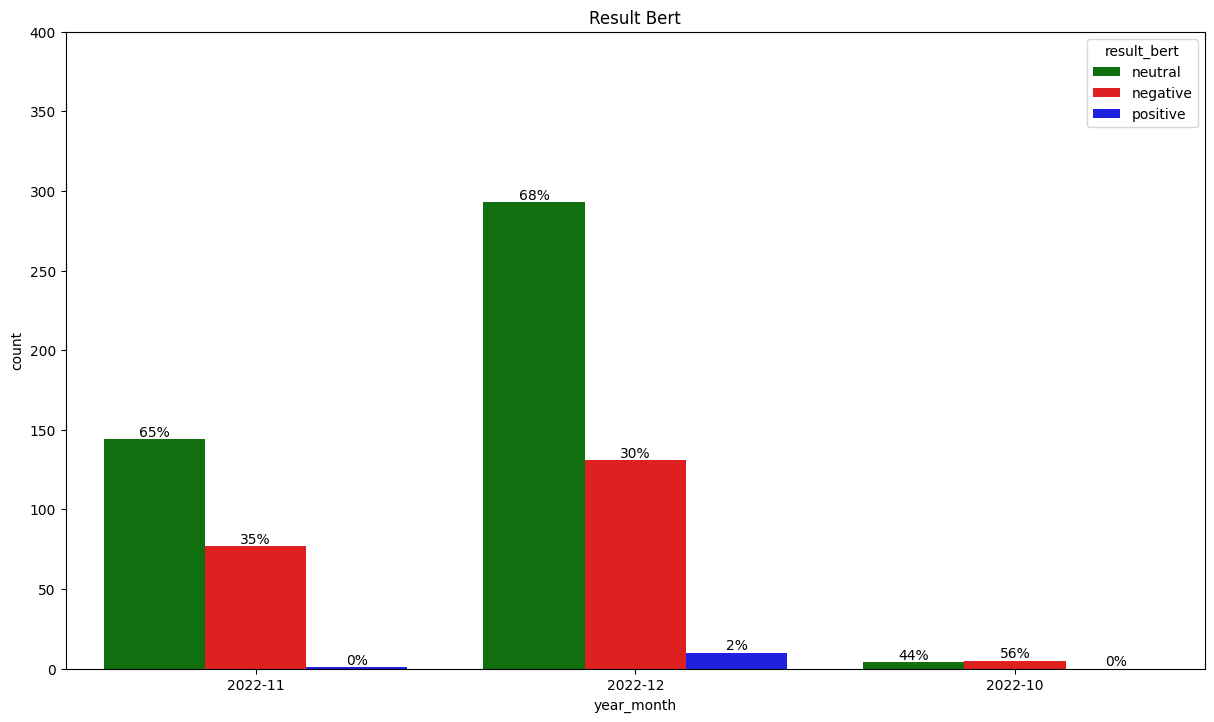

In [16]:
# Define your custom color palette
custom_palette = {
    'positive': 'blue',
    'negative': 'red',
    'neutral': 'green'
}

plt.figure(figsize=[14.70, 8.27])

# Create a count plot for 'result_bert' with fixed colors
ax1 = sb.countplot(x='year_month', hue='result_bert', data=df_final, palette=custom_palette)
ax1.set_title('Result Bert')

# # Create a count plot for 'result_roberta' with the same fixed colors
# ax2 = sb.countplot(x='year_month', hue='result_roberta', data=df_final, palette=custom_palette)
# ax2.set_title('Result Roberta')

# Call barPerc with the updated axes for both 'result_bert' and 'result_roberta'
barPerc(df_final, 'year_month', ax1)
# barPerc(df_final, 'year_month', ax2)
ax1.set(ylim=(0, 400))

# **Sentiment Plots for Time Frame 3 xlm-Roberta Results**

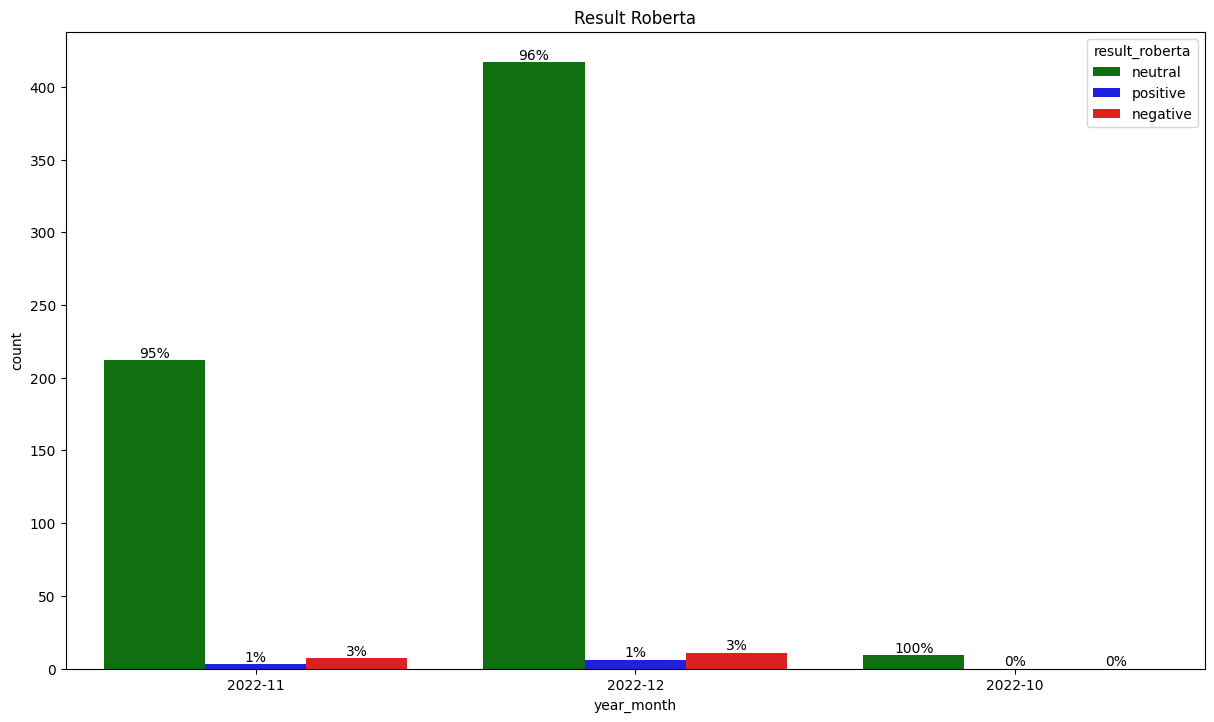

In [17]:

# Define your custom color palette
custom_palette = {
    'positive': 'blue',
    'negative': 'red',
    'neutral': 'green'
}

plt.figure(figsize=[14.70, 8.27])

# Create a count plot for 'result_bert' with fixed colors
# ax1 = sb.countplot(x='year_month', hue='result_bert', data=df_final, palette=custom_palette)
# ax1.set_title('Result Bert')

# # Create a count plot for 'result_roberta' with the same fixed colors
ax2 = sb.countplot(x='year_month', hue='result_roberta', data=df_final, palette=custom_palette)
ax2.set_title('Result Roberta')

# Call barPerc with the updated axes for both 'result_bert' and 'result_roberta'
#barPerc(df_final, 'year_month', ax1)
barPerc(df_final, 'year_month', ax2)


## **Jan-May 2023 (Time Frame 4) dataset**

In [18]:
# Define directory path
dir_path = '/content/drive/MyDrive/Data Set/2023_Tweets/'

# Initialize empty list to store data
data_list = []
df_combined = pd.DataFrame()

# Loop over all files in directory
for filename in os.listdir(dir_path):
    if filename.endswith('.json'):
        # Read JSON file
        dff = pd.read_json(os.path.join(dir_path, filename))
        df_text = dff[['text', 'created_at']]

        # Apply text cleaning
        df_text['text_cleaned'] = df_text['text'].apply(clean_text)

        # Concatenate cleaned text to the DataFrame
        df_combined = pd.concat([df_combined, df_text], ignore_index=True)

df_combined.rename(columns={0: 'text'}, inplace=True)
df_combined

<ipython-input-18-4e6172277e8a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['text_cleaned'] = df_text['text'].apply(clean_text)


,text,created_at,text_cleaned
0,"Großbritannien, Finnland, Japan und viele ande...",2023-03-07 22:00:31,großbritannien finnland japan viele länder bau...
1,Top bezahlte und krisensichere Jobs für top au...,2023-03-08 07:12:29,top bezahlte krisensichere job top ausgebildet...
2,"Die Pro-Atom-Kampagne von FDP, Union und AfD u...",2023-03-08 06:30:09,pro atom kampagne fdp union afd unterschlägt f...
3,ZUM GLÜCK STEHT DEM NOCH EIN GESETZ ENTGEGEN! ...,2023-03-08 08:42:33,glück steht gesetz entgegen schweizer rechtsau...
4,Sind die #AKW eigentlich schon aus? Ist doch s...,2023-03-08 10:31:07,akw eigentlich schon schon märz hört gar mehr ...
...,...,...,...
3504,Herausragende Dokumentation von \u2066@ZDF\u20...,2023-05-02 17:32:44,herausragende dokumentation zdf nuklearkatastr...
3505,#Krieg #Nuklearmacht #Eskalation \n\neine groß...,2023-01-09 00:39:48,krieg nuklearmacht eskalation neine große nukl...
3506,https://t.co/Z4bDMkRtQz \n\nehemaliger General...,2023-01-11 05:05:40,nehemaliger generalinspekteur nuklearmacht bes...
3507,#Luetzerath \n\nWo kann ich bitte einen #Nukle...,2023-01-15 00:26:20,luetzerath nwo bitte nuklearreaktor vorzugswei...


In [19]:
word_length_list =[]
for item in df_combined['text_cleaned']:
  words = item.split()
  word_length_list.append(len(words))
df_combined['Lenght of cleaned_text'] = word_length_list
df_combined

,text,created_at,text_cleaned,Lenght of cleaned_text
0,"Großbritannien, Finnland, Japan und viele ande...",2023-03-07 22:00:31,großbritannien finnland japan viele länder bau...,22
1,Top bezahlte und krisensichere Jobs für top au...,2023-03-08 07:12:29,top bezahlte krisensichere job top ausgebildet...,17
2,"Die Pro-Atom-Kampagne von FDP, Union und AfD u...",2023-03-08 06:30:09,pro atom kampagne fdp union afd unterschlägt f...,15
3,ZUM GLÜCK STEHT DEM NOCH EIN GESETZ ENTGEGEN! ...,2023-03-08 08:42:33,glück steht gesetz entgegen schweizer rechtsau...,22
4,Sind die #AKW eigentlich schon aus? Ist doch s...,2023-03-08 10:31:07,akw eigentlich schon schon märz hört gar mehr ...,15
...,...,...,...,...
3504,Herausragende Dokumentation von \u2066@ZDF\u20...,2023-05-02 17:32:44,herausragende dokumentation zdf nuklearkatastr...,13
3505,#Krieg #Nuklearmacht #Eskalation \n\neine groß...,2023-01-09 00:39:48,krieg nuklearmacht eskalation neine große nukl...,17
3506,https://t.co/Z4bDMkRtQz \n\nehemaliger General...,2023-01-11 05:05:40,nehemaliger generalinspekteur nuklearmacht bes...,11
3507,#Luetzerath \n\nWo kann ich bitte einen #Nukle...,2023-01-15 00:26:20,luetzerath nwo bitte nuklearreaktor vorzugswei...,22


In [20]:
df_combined['Lenght of cleaned_text'].mean()

17.263607865488744

# **Jan-May 2023 (Time Frame 4) Bert Results**

In [21]:
model = SentimentModel()

texts = df_combined['text_cleaned']

result1 = model.predict_sentiment(texts)

In [22]:
df_final = df_combined
df_final['result_bert'] = result1
df_final

,text,created_at,text_cleaned,Lenght of cleaned_text,result_bert
0,"Großbritannien, Finnland, Japan und viele ande...",2023-03-07 22:00:31,großbritannien finnland japan viele länder bau...,22,negative
1,Top bezahlte und krisensichere Jobs für top au...,2023-03-08 07:12:29,top bezahlte krisensichere job top ausgebildet...,17,positive
2,"Die Pro-Atom-Kampagne von FDP, Union und AfD u...",2023-03-08 06:30:09,pro atom kampagne fdp union afd unterschlägt f...,15,neutral
3,ZUM GLÜCK STEHT DEM NOCH EIN GESETZ ENTGEGEN! ...,2023-03-08 08:42:33,glück steht gesetz entgegen schweizer rechtsau...,22,neutral
4,Sind die #AKW eigentlich schon aus? Ist doch s...,2023-03-08 10:31:07,akw eigentlich schon schon märz hört gar mehr ...,15,negative
...,...,...,...,...,...
3504,Herausragende Dokumentation von \u2066@ZDF\u20...,2023-05-02 17:32:44,herausragende dokumentation zdf nuklearkatastr...,13,neutral
3505,#Krieg #Nuklearmacht #Eskalation \n\neine groß...,2023-01-09 00:39:48,krieg nuklearmacht eskalation neine große nukl...,17,negative
3506,https://t.co/Z4bDMkRtQz \n\nehemaliger General...,2023-01-11 05:05:40,nehemaliger generalinspekteur nuklearmacht bes...,11,negative
3507,#Luetzerath \n\nWo kann ich bitte einen #Nukle...,2023-01-15 00:26:20,luetzerath nwo bitte nuklearreaktor vorzugswei...,22,negative


# **Jan-May 2023 (Time Frame 4) xlm-Roberta Results**

In [23]:
model_path = "citizenlab/twitter-xlm-roberta-base-sentiment-finetunned"

sentiment_classifier = pipeline("text-classification", model=model_path, tokenizer=model_path)
result1 =[]
for l in df_combined['text_cleaned']:
  result1.append(sentiment_classifier(l))

result1

[[{'label': 'Neutral', 'score': 0.9905953407287598}],
 [{'label': 'Neutral', 'score': 0.9886427521705627}],
 [{'label': 'Neutral', 'score': 0.9907534122467041}],
 [{'label': 'Neutral', 'score': 0.9869988560676575}],
 [{'label': 'Neutral', 'score': 0.9794140458106995}],
 [{'label': 'Negative', 'score': 0.5641844868659973}],
 [{'label': 'Neutral', 'score': 0.9795593023300171}],
 [{'label': 'Neutral', 'score': 0.9847671389579773}],
 [{'label': 'Neutral', 'score': 0.8041666150093079}],
 [{'label': 'Neutral', 'score': 0.9865946769714355}],
 [{'label': 'Neutral', 'score': 0.9690986275672913}],
 [{'label': 'Neutral', 'score': 0.9896841049194336}],
 [{'label': 'Neutral', 'score': 0.9697061777114868}],
 [{'label': 'Neutral', 'score': 0.9881467223167419}],
 [{'label': 'Neutral', 'score': 0.9881467223167419}],
 [{'label': 'Neutral', 'score': 0.9891198873519897}],
 [{'label': 'Neutral', 'score': 0.9891052842140198}],
 [{'label': 'Neutral', 'score': 0.9756318926811218}],
 [{'label': 'Neutral', 'sco

In [24]:
labels_sent = [d['label'] for lst2 in result1 for d in lst2]
df_senti_model=pd.DataFrame(labels_sent)
#df_senti_model[0:]
df_senti_model = df_senti_model[0].str.lower()
df_senti_model

0        neutral
1        neutral
2        neutral
3        neutral
4        neutral
          ...   
3504    positive
3505     neutral
3506     neutral
3507     neutral
3508     neutral
Name: 0, Length: 3509, dtype: object

In [25]:
df_final = df_combined
df_final['result_roberta'] =df_senti_model
df_final

,text,created_at,text_cleaned,Lenght of cleaned_text,result_bert,result_roberta
0,"Großbritannien, Finnland, Japan und viele ande...",2023-03-07 22:00:31,großbritannien finnland japan viele länder bau...,22,negative,neutral
1,Top bezahlte und krisensichere Jobs für top au...,2023-03-08 07:12:29,top bezahlte krisensichere job top ausgebildet...,17,positive,neutral
2,"Die Pro-Atom-Kampagne von FDP, Union und AfD u...",2023-03-08 06:30:09,pro atom kampagne fdp union afd unterschlägt f...,15,neutral,neutral
3,ZUM GLÜCK STEHT DEM NOCH EIN GESETZ ENTGEGEN! ...,2023-03-08 08:42:33,glück steht gesetz entgegen schweizer rechtsau...,22,neutral,neutral
4,Sind die #AKW eigentlich schon aus? Ist doch s...,2023-03-08 10:31:07,akw eigentlich schon schon märz hört gar mehr ...,15,negative,neutral
...,...,...,...,...,...,...
3504,Herausragende Dokumentation von \u2066@ZDF\u20...,2023-05-02 17:32:44,herausragende dokumentation zdf nuklearkatastr...,13,neutral,positive
3505,#Krieg #Nuklearmacht #Eskalation \n\neine groß...,2023-01-09 00:39:48,krieg nuklearmacht eskalation neine große nukl...,17,negative,neutral
3506,https://t.co/Z4bDMkRtQz \n\nehemaliger General...,2023-01-11 05:05:40,nehemaliger generalinspekteur nuklearmacht bes...,11,negative,neutral
3507,#Luetzerath \n\nWo kann ich bitte einen #Nukle...,2023-01-15 00:26:20,luetzerath nwo bitte nuklearreaktor vorzugswei...,22,negative,neutral


In [26]:
df_final['created_at'] = pd.to_datetime(df_final['created_at'])

# Extract just the date portion
df_final['created_at'] = pd.to_datetime(df_final['created_at']).dt.date

df_final['year_month'] = pd.to_datetime(df_final['created_at']).dt.strftime('%Y-%m')
df_final

,text,created_at,text_cleaned,Lenght of cleaned_text,result_bert,result_roberta,year_month
0,"Großbritannien, Finnland, Japan und viele ande...",2023-03-07,großbritannien finnland japan viele länder bau...,22,negative,neutral,2023-03
1,Top bezahlte und krisensichere Jobs für top au...,2023-03-08,top bezahlte krisensichere job top ausgebildet...,17,positive,neutral,2023-03
2,"Die Pro-Atom-Kampagne von FDP, Union und AfD u...",2023-03-08,pro atom kampagne fdp union afd unterschlägt f...,15,neutral,neutral,2023-03
3,ZUM GLÜCK STEHT DEM NOCH EIN GESETZ ENTGEGEN! ...,2023-03-08,glück steht gesetz entgegen schweizer rechtsau...,22,neutral,neutral,2023-03
4,Sind die #AKW eigentlich schon aus? Ist doch s...,2023-03-08,akw eigentlich schon schon märz hört gar mehr ...,15,negative,neutral,2023-03
...,...,...,...,...,...,...,...
3504,Herausragende Dokumentation von \u2066@ZDF\u20...,2023-05-02,herausragende dokumentation zdf nuklearkatastr...,13,neutral,positive,2023-05
3505,#Krieg #Nuklearmacht #Eskalation \n\neine groß...,2023-01-09,krieg nuklearmacht eskalation neine große nukl...,17,negative,neutral,2023-01
3506,https://t.co/Z4bDMkRtQz \n\nehemaliger General...,2023-01-11,nehemaliger generalinspekteur nuklearmacht bes...,11,negative,neutral,2023-01
3507,#Luetzerath \n\nWo kann ich bitte einen #Nukle...,2023-01-15,luetzerath nwo bitte nuklearreaktor vorzugswei...,22,negative,neutral,2023-01


In [28]:
df_final.to_csv("/content/drive/MyDrive/Derived_data/bert_roberta_2023.csv")

In [31]:
def barPerc(df,xVar,ax):
    '''
    barPerc(): Add percentage for hues to bar plots
    args:
        df: pandas dataframe
        xVar: (string) X variable
        ax: Axes object (for Seaborn Countplot/Bar plot or
                         pandas bar plot)
    '''
    # 1. how many X categories
    ##   check for NaN and remove
    numX=len([x for x in df[xVar].unique() if x==x])

    # 2. The bars are created in hue order, organize them
    bars = ax.patches
    ## 2a. For each X variable
    for ind in range(numX):
        ## 2b. Get every hue bar
        ##     ex. 8 X categories, 4 hues =>
        ##    [0, 8, 16, 24] are hue bars for 1st X category
        hueBars=bars[ind:][::numX]
        ## 2c. Get the total height (for percentages)
        total = sum([x.get_height() for x in hueBars])

        # 3. Print the percentage on the bars
        for bar in hueBars:
            ax.text(bar.get_x() + bar.get_width()/2.,
                    bar.get_height(),
                    f'{bar.get_height()/total:.0%}',
                    ha="center",va="bottom")

[(0.0, 3000.0)]

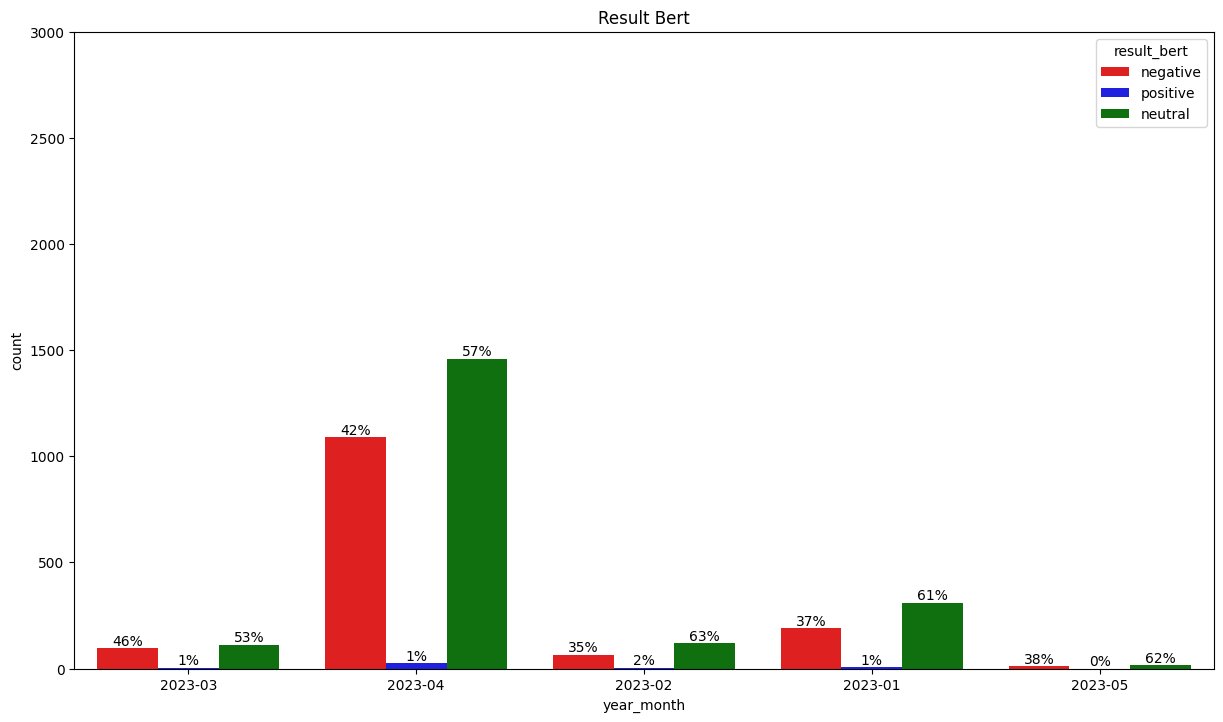

In [32]:
import matplotlib.pyplot as plt
import seaborn as sb

# Define your custom color palette
custom_palette = {
    'positive': 'blue',
    'negative': 'red',
    'neutral': 'green'
}

plt.figure(figsize=[14.70, 8.27])

# Create a count plot for 'result_bert' with fixed colors
ax1 = sb.countplot(x='year_month', hue='result_bert', data=df_final, palette=custom_palette)
ax1.set_title('Result Bert')

# # Create a count plot for 'result_roberta' with the same fixed colors
# ax2 = sb.countplot(x='year_month', hue='result_roberta', data=df_final, palette=custom_palette)
# ax2.set_title('Result Roberta')

# Call barPerc with the updated axes for both 'result_bert' and 'result_roberta'
barPerc(df_final, 'year_month', ax1)
# barPerc(df_final, 'year_month', ax2)
ax1.set(ylim=(0, 3000))

[(0.0, 3000.0)]

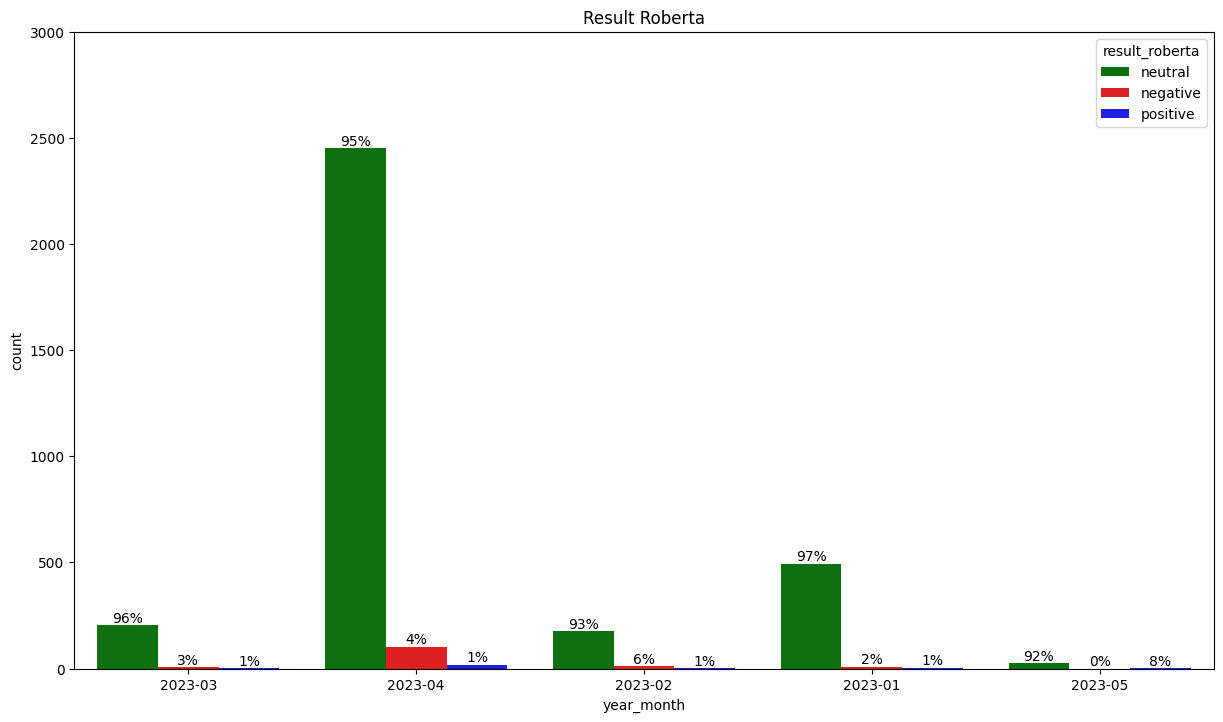

In [33]:
import matplotlib.pyplot as plt
import seaborn as sb

# Define your custom color palette
custom_palette = {
    'positive': 'blue',
    'negative': 'red',
    'neutral': 'green'
}

plt.figure(figsize=[14.70, 8.27])

# Create a count plot for 'result_bert' with fixed colors
# ax1 = sb.countplot(x='year_month', hue='result_roberta', data=df_final, palette=custom_palette)
# ax1.set_title('Result Roberta')

# # Create a count plot for 'result_roberta' with the same fixed colors
ax2 = sb.countplot(x='year_month', hue='result_roberta', data=df_final, palette=custom_palette)
ax2.set_title('Result Roberta')

# Call barPerc with the updated axes for both 'result_bert' and 'result_roberta'
#barPerc(df_final, 'year_month', ax1)
barPerc(df_final, 'year_month', ax2)
ax2.set(ylim=(0, 3000))

# **January 2022 (Time Frame 2) dataset**

In [34]:
import os
# Define directory path
dir_path = '/content/drive/MyDrive/Data Set/2022_Nov_11_AKW/'

# Initialize empty list to store data
data_list = []
df_combined = pd.DataFrame()

# Loop over all files in directory
for filename in os.listdir(dir_path):
    if filename.endswith('.json'):
        # Read JSON file
        dff = pd.read_json(os.path.join(dir_path, filename))
        df_text = dff[['text', 'created_at']]

        # Apply text cleaning
        df_text['text_cleaned'] = df_text['text'].apply(clean_text)

        # Concatenate cleaned text to the DataFrame
        df_combined = pd.concat([df_combined, df_text], ignore_index=True)

df_combined.rename(columns={0: 'text'}, inplace=True)
df_combined

<ipython-input-34-063a3296f6e9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['text_cleaned'] = df_text['text'].apply(clean_text)
<ipython-input-34-063a3296f6e9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['text_cleaned'] = df_text['text'].apply(clean_text)
<ipython-input-34-063a3296f6e9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

,text,created_at,text_cleaned
0,RT @JU_MucNord: Deutschland schaltet besonders...,2022-01-01 23:35:31+00:00,ju mucnord deutschland schaltet besonders sich...
1,"""Absolut falsch,…#Atomkraft in die #Taxonomie ...",2022-01-01 23:34:54+00:00,absolut falsch atomkraft taxonomie nachhaltige...
2,RT @marcfriedrich7: Lol:\n\nEU labelt Gas und ...,2022-01-01 23:34:39+00:00,marcfriedrich lol eu labelt gas atomkraft grün...
3,"RT @realTomBohn: „Deutschland, das Milliarden ...",2022-01-01 23:33:43+00:00,realtombohn deutschland milliarden ausstieg au...
4,"RT @realTomBohn: „Deutschland, das Milliarden ...",2022-01-01 23:33:21+00:00,realtombohn deutschland milliarden ausstieg au...
...,...,...,...
12349,"""Was die erste Reihe der Partei [grüne] da an ...",2022-01-04 11:39:17+00:00,erste reihe partei grüne bigotter selbstrechtf...
12350,"RT @Alice_Weidel: Ob es ums #Klima, die #Migra...",2022-01-04 11:39:02+00:00,alice weidel ums klima migration euro eu gesun...
12351,#Atomkraft \n\nFakt 1: der Ausstieg ist vertra...,2022-01-04 11:38:10+00:00,atomkraft fakt ausstieg vertraglich abgesicher...
12352,Der Schuss geht nach hinten los #Gas #Atomkraf...,2022-01-04 11:37:48+00:00,schuss geht hinten los gas atomkraft kernenergie


# **January 2022 (Time Frame 2) Bert Results**

In [35]:
model = SentimentModel()
texts = df_combined['text_cleaned'].iloc[0:2000]
result1 = model.predict_sentiment(texts)

In [36]:
texts = df_combined['text_cleaned'].iloc[2000:4000]
result2 = model.predict_sentiment(texts)

In [37]:
texts = df_combined['text_cleaned'].iloc[4000:6000]
result3 = model.predict_sentiment(texts)

In [38]:
texts = df_combined['text_cleaned'].iloc[6000:8000]
result4 = model.predict_sentiment(texts)

In [39]:
texts = df_combined['text_cleaned'].iloc[8000:10000]
result5 = model.predict_sentiment(texts)

In [40]:
texts = df_combined['text_cleaned'].iloc[10000:12354]
result6 = model.predict_sentiment(texts)

In [41]:
result_bert=result1+result2+result3+result4+result5+result6

In [42]:
df_final = df_combined
df_final['result_bert'] = result_bert
df_final

,text,created_at,text_cleaned,result_bert
0,RT @JU_MucNord: Deutschland schaltet besonders...,2022-01-01 23:35:31+00:00,ju mucnord deutschland schaltet besonders sich...,neutral
1,"""Absolut falsch,…#Atomkraft in die #Taxonomie ...",2022-01-01 23:34:54+00:00,absolut falsch atomkraft taxonomie nachhaltige...,negative
2,RT @marcfriedrich7: Lol:\n\nEU labelt Gas und ...,2022-01-01 23:34:39+00:00,marcfriedrich lol eu labelt gas atomkraft grün...,neutral
3,"RT @realTomBohn: „Deutschland, das Milliarden ...",2022-01-01 23:33:43+00:00,realtombohn deutschland milliarden ausstieg au...,neutral
4,"RT @realTomBohn: „Deutschland, das Milliarden ...",2022-01-01 23:33:21+00:00,realtombohn deutschland milliarden ausstieg au...,neutral
...,...,...,...,...
12349,"""Was die erste Reihe der Partei [grüne] da an ...",2022-01-04 11:39:17+00:00,erste reihe partei grüne bigotter selbstrechtf...,neutral
12350,"RT @Alice_Weidel: Ob es ums #Klima, die #Migra...",2022-01-04 11:39:02+00:00,alice weidel ums klima migration euro eu gesun...,neutral
12351,#Atomkraft \n\nFakt 1: der Ausstieg ist vertra...,2022-01-04 11:38:10+00:00,atomkraft fakt ausstieg vertraglich abgesicher...,neutral
12352,Der Schuss geht nach hinten los #Gas #Atomkraf...,2022-01-04 11:37:48+00:00,schuss geht hinten los gas atomkraft kernenergie,negative


# **January 2022 (Time Frame 2) xlm-Roberta Results**

In [43]:
model_path = "citizenlab/twitter-xlm-roberta-base-sentiment-finetunned"

sentiment_classifier = pipeline("text-classification", model=model_path, tokenizer=model_path)
result1 =[]
for l in df_combined['text_cleaned'].iloc[0:2000]:
  result1.append(sentiment_classifier(l))

result1

[[{'label': 'Neutral', 'score': 0.9878958463668823}],
 [{'label': 'Negative', 'score': 0.883892834186554}],
 [{'label': 'Neutral', 'score': 0.9916948676109314}],
 [{'label': 'Neutral', 'score': 0.9881954193115234}],
 [{'label': 'Neutral', 'score': 0.9881954193115234}],
 [{'label': 'Neutral', 'score': 0.9881600141525269}],
 [{'label': 'Neutral', 'score': 0.987400233745575}],
 [{'label': 'Neutral', 'score': 0.9919289350509644}],
 [{'label': 'Neutral', 'score': 0.9906489253044128}],
 [{'label': 'Neutral', 'score': 0.990874171257019}],
 [{'label': 'Neutral', 'score': 0.9881954193115234}],
 [{'label': 'Neutral', 'score': 0.9913722276687622}],
 [{'label': 'Neutral', 'score': 0.9877612590789795}],
 [{'label': 'Neutral', 'score': 0.5927301049232483}],
 [{'label': 'Neutral', 'score': 0.9916948676109314}],
 [{'label': 'Neutral', 'score': 0.9834780097007751}],
 [{'label': 'Neutral', 'score': 0.9851803779602051}],
 [{'label': 'Neutral', 'score': 0.9872351288795471}],
 [{'label': 'Neutral', 'score'

In [44]:
result2 =[]
for l in df_combined['text_cleaned'].iloc[2000:4000]:
  result2.append(sentiment_classifier(l))

result2

[[{'label': 'Neutral', 'score': 0.9801022410392761}],
 [{'label': 'Neutral', 'score': 0.9878959655761719}],
 [{'label': 'Neutral', 'score': 0.9871362447738647}],
 [{'label': 'Neutral', 'score': 0.9898970127105713}],
 [{'label': 'Neutral', 'score': 0.9899531006813049}],
 [{'label': 'Neutral', 'score': 0.983523428440094}],
 [{'label': 'Neutral', 'score': 0.9867262840270996}],
 [{'label': 'Neutral', 'score': 0.9905062317848206}],
 [{'label': 'Neutral', 'score': 0.9878387451171875}],
 [{'label': 'Neutral', 'score': 0.9917952418327332}],
 [{'label': 'Neutral', 'score': 0.9873008728027344}],
 [{'label': 'Neutral', 'score': 0.9898043870925903}],
 [{'label': 'Neutral', 'score': 0.9854250550270081}],
 [{'label': 'Neutral', 'score': 0.990911066532135}],
 [{'label': 'Neutral', 'score': 0.9907007217407227}],
 [{'label': 'Neutral', 'score': 0.9881954193115234}],
 [{'label': 'Neutral', 'score': 0.9892851710319519}],
 [{'label': 'Neutral', 'score': 0.9897907376289368}],
 [{'label': 'Neutral', 'score'

In [45]:
result3 =[]
for l in df_combined['text_cleaned'].iloc[4000:6000]:
  result3.append(sentiment_classifier(l))

result3

[[{'label': 'Neutral', 'score': 0.9910796284675598}],
 [{'label': 'Neutral', 'score': 0.9602298140525818}],
 [{'label': 'Neutral', 'score': 0.9859530925750732}],
 [{'label': 'Neutral', 'score': 0.9893161058425903}],
 [{'label': 'Neutral', 'score': 0.9582700729370117}],
 [{'label': 'Neutral', 'score': 0.9881306886672974}],
 [{'label': 'Neutral', 'score': 0.9893161058425903}],
 [{'label': 'Neutral', 'score': 0.9870907068252563}],
 [{'label': 'Neutral', 'score': 0.987237811088562}],
 [{'label': 'Neutral', 'score': 0.9859530925750732}],
 [{'label': 'Neutral', 'score': 0.9884190559387207}],
 [{'label': 'Neutral', 'score': 0.9878644347190857}],
 [{'label': 'Neutral', 'score': 0.9905371069908142}],
 [{'label': 'Neutral', 'score': 0.9905224442481995}],
 [{'label': 'Neutral', 'score': 0.9772602915763855}],
 [{'label': 'Neutral', 'score': 0.9910796284675598}],
 [{'label': 'Neutral', 'score': 0.987497091293335}],
 [{'label': 'Neutral', 'score': 0.9913802742958069}],
 [{'label': 'Neutral', 'score'

In [46]:
result4 =[]
for l in df_combined['text_cleaned'].iloc[6000:8000]:
  result4.append(sentiment_classifier(l))

result4

[[{'label': 'Neutral', 'score': 0.808491051197052}],
 [{'label': 'Neutral', 'score': 0.9899770617485046}],
 [{'label': 'Neutral', 'score': 0.9870228171348572}],
 [{'label': 'Neutral', 'score': 0.989325761795044}],
 [{'label': 'Neutral', 'score': 0.9853057265281677}],
 [{'label': 'Neutral', 'score': 0.990256130695343}],
 [{'label': 'Neutral', 'score': 0.9857162833213806}],
 [{'label': 'Neutral', 'score': 0.9826200604438782}],
 [{'label': 'Neutral', 'score': 0.9887388944625854}],
 [{'label': 'Neutral', 'score': 0.9853057265281677}],
 [{'label': 'Neutral', 'score': 0.9889320135116577}],
 [{'label': 'Neutral', 'score': 0.990250289440155}],
 [{'label': 'Neutral', 'score': 0.9834780097007751}],
 [{'label': 'Neutral', 'score': 0.989443302154541}],
 [{'label': 'Neutral', 'score': 0.9742881059646606}],
 [{'label': 'Neutral', 'score': 0.9391883015632629}],
 [{'label': 'Neutral', 'score': 0.9870228171348572}],
 [{'label': 'Neutral', 'score': 0.9890559911727905}],
 [{'label': 'Neutral', 'score': 0

In [47]:
result5 =[]
for l in df_combined['text_cleaned'].iloc[8000:10000]:
  result5.append(sentiment_classifier(l))

result5

[[{'label': 'Neutral', 'score': 0.992660641670227}],
 [{'label': 'Neutral', 'score': 0.9790369868278503}],
 [{'label': 'Neutral', 'score': 0.9790369868278503}],
 [{'label': 'Neutral', 'score': 0.9790369868278503}],
 [{'label': 'Neutral', 'score': 0.9635984301567078}],
 [{'label': 'Neutral', 'score': 0.9906489253044128}],
 [{'label': 'Neutral', 'score': 0.9897811412811279}],
 [{'label': 'Neutral', 'score': 0.9790369868278503}],
 [{'label': 'Neutral', 'score': 0.9911393523216248}],
 [{'label': 'Neutral', 'score': 0.9900649189949036}],
 [{'label': 'Neutral', 'score': 0.9790369868278503}],
 [{'label': 'Neutral', 'score': 0.9897907376289368}],
 [{'label': 'Neutral', 'score': 0.9872351288795471}],
 [{'label': 'Neutral', 'score': 0.9921759963035583}],
 [{'label': 'Neutral', 'score': 0.9899516701698303}],
 [{'label': 'Neutral', 'score': 0.9906963109970093}],
 [{'label': 'Neutral', 'score': 0.9904544949531555}],
 [{'label': 'Neutral', 'score': 0.9637677073478699}],
 [{'label': 'Neutral', 'score

In [48]:
result6 =[]
for l in df_combined['text_cleaned'].iloc[10000:12354]:
  result6.append(sentiment_classifier(l))

result6

[[{'label': 'Neutral', 'score': 0.9834780097007751}],
 [{'label': 'Neutral', 'score': 0.9881954193115234}],
 [{'label': 'Neutral', 'score': 0.9904548525810242}],
 [{'label': 'Neutral', 'score': 0.9881954193115234}],
 [{'label': 'Neutral', 'score': 0.9891687631607056}],
 [{'label': 'Neutral', 'score': 0.5132014751434326}],
 [{'label': 'Neutral', 'score': 0.9917747974395752}],
 [{'label': 'Neutral', 'score': 0.9899516701698303}],
 [{'label': 'Neutral', 'score': 0.9877344965934753}],
 [{'label': 'Neutral', 'score': 0.99032062292099}],
 [{'label': 'Neutral', 'score': 0.9896945953369141}],
 [{'label': 'Neutral', 'score': 0.9878308176994324}],
 [{'label': 'Neutral', 'score': 0.9879332184791565}],
 [{'label': 'Neutral', 'score': 0.984444260597229}],
 [{'label': 'Neutral', 'score': 0.99032062292099}],
 [{'label': 'Neutral', 'score': 0.9919000864028931}],
 [{'label': 'Neutral', 'score': 0.9878958463668823}],
 [{'label': 'Neutral', 'score': 0.9875368475914001}],
 [{'label': 'Neutral', 'score': 0

In [49]:
result_roberta=result1+result2+result3+result4+result5+result6

In [50]:
labels_sent = [d['label'] for lst2 in result_roberta for d in lst2]
df_senti_model=pd.DataFrame(labels_sent)
#df_senti_model[0:]
df_senti_model = df_senti_model[0].str.lower()
df_senti_model

0         neutral
1        negative
2         neutral
3         neutral
4         neutral
           ...   
12349     neutral
12350     neutral
12351     neutral
12352     neutral
12353     neutral
Name: 0, Length: 12354, dtype: object

In [51]:
df_final = df_combined
df_final['result_roberta'] =df_senti_model
df_final

,text,created_at,text_cleaned,result_bert,result_roberta
0,RT @JU_MucNord: Deutschland schaltet besonders...,2022-01-01 23:35:31+00:00,ju mucnord deutschland schaltet besonders sich...,neutral,neutral
1,"""Absolut falsch,…#Atomkraft in die #Taxonomie ...",2022-01-01 23:34:54+00:00,absolut falsch atomkraft taxonomie nachhaltige...,negative,negative
2,RT @marcfriedrich7: Lol:\n\nEU labelt Gas und ...,2022-01-01 23:34:39+00:00,marcfriedrich lol eu labelt gas atomkraft grün...,neutral,neutral
3,"RT @realTomBohn: „Deutschland, das Milliarden ...",2022-01-01 23:33:43+00:00,realtombohn deutschland milliarden ausstieg au...,neutral,neutral
4,"RT @realTomBohn: „Deutschland, das Milliarden ...",2022-01-01 23:33:21+00:00,realtombohn deutschland milliarden ausstieg au...,neutral,neutral
...,...,...,...,...,...
12349,"""Was die erste Reihe der Partei [grüne] da an ...",2022-01-04 11:39:17+00:00,erste reihe partei grüne bigotter selbstrechtf...,neutral,neutral
12350,"RT @Alice_Weidel: Ob es ums #Klima, die #Migra...",2022-01-04 11:39:02+00:00,alice weidel ums klima migration euro eu gesun...,neutral,neutral
12351,#Atomkraft \n\nFakt 1: der Ausstieg ist vertra...,2022-01-04 11:38:10+00:00,atomkraft fakt ausstieg vertraglich abgesicher...,neutral,neutral
12352,Der Schuss geht nach hinten los #Gas #Atomkraf...,2022-01-04 11:37:48+00:00,schuss geht hinten los gas atomkraft kernenergie,negative,neutral


In [52]:
df_final['created_at'] = pd.to_datetime(df_final['created_at'])

# Extract just the date portion
df_final['created_at'] = pd.to_datetime(df_final['created_at']).dt.date

df_final['year_month'] = pd.to_datetime(df_final['created_at']).dt.strftime('%Y-%m')
df_final

,text,created_at,text_cleaned,result_bert,result_roberta,year_month
0,RT @JU_MucNord: Deutschland schaltet besonders...,2022-01-01,ju mucnord deutschland schaltet besonders sich...,neutral,neutral,2022-01
1,"""Absolut falsch,…#Atomkraft in die #Taxonomie ...",2022-01-01,absolut falsch atomkraft taxonomie nachhaltige...,negative,negative,2022-01
2,RT @marcfriedrich7: Lol:\n\nEU labelt Gas und ...,2022-01-01,marcfriedrich lol eu labelt gas atomkraft grün...,neutral,neutral,2022-01
3,"RT @realTomBohn: „Deutschland, das Milliarden ...",2022-01-01,realtombohn deutschland milliarden ausstieg au...,neutral,neutral,2022-01
4,"RT @realTomBohn: „Deutschland, das Milliarden ...",2022-01-01,realtombohn deutschland milliarden ausstieg au...,neutral,neutral,2022-01
...,...,...,...,...,...,...
12349,"""Was die erste Reihe der Partei [grüne] da an ...",2022-01-04,erste reihe partei grüne bigotter selbstrechtf...,neutral,neutral,2022-01
12350,"RT @Alice_Weidel: Ob es ums #Klima, die #Migra...",2022-01-04,alice weidel ums klima migration euro eu gesun...,neutral,neutral,2022-01
12351,#Atomkraft \n\nFakt 1: der Ausstieg ist vertra...,2022-01-04,atomkraft fakt ausstieg vertraglich abgesicher...,neutral,neutral,2022-01
12352,Der Schuss geht nach hinten los #Gas #Atomkraf...,2022-01-04,schuss geht hinten los gas atomkraft kernenergie,negative,neutral,2022-01


In [53]:
word_length_list =[]
for item in df_final['text_cleaned']:
  words = item.split()
  word_length_list.append(len(words))
df_final['Lenght of cleaned_text'] = word_length_list
df_final


,text,created_at,text_cleaned,result_bert,result_roberta,year_month,Lenght of cleaned_text
0,RT @JU_MucNord: Deutschland schaltet besonders...,2022-01-01,ju mucnord deutschland schaltet besonders sich...,neutral,neutral,2022-01,14
1,"""Absolut falsch,…#Atomkraft in die #Taxonomie ...",2022-01-01,absolut falsch atomkraft taxonomie nachhaltige...,negative,negative,2022-01,19
2,RT @marcfriedrich7: Lol:\n\nEU labelt Gas und ...,2022-01-01,marcfriedrich lol eu labelt gas atomkraft grün...,neutral,neutral,2022-01,10
3,"RT @realTomBohn: „Deutschland, das Milliarden ...",2022-01-01,realtombohn deutschland milliarden ausstieg au...,neutral,neutral,2022-01,11
4,"RT @realTomBohn: „Deutschland, das Milliarden ...",2022-01-01,realtombohn deutschland milliarden ausstieg au...,neutral,neutral,2022-01,11
...,...,...,...,...,...,...,...
12349,"""Was die erste Reihe der Partei [grüne] da an ...",2022-01-04,erste reihe partei grüne bigotter selbstrechtf...,neutral,neutral,2022-01,20
12350,"RT @Alice_Weidel: Ob es ums #Klima, die #Migra...",2022-01-04,alice weidel ums klima migration euro eu gesun...,neutral,neutral,2022-01,12
12351,#Atomkraft \n\nFakt 1: der Ausstieg ist vertra...,2022-01-04,atomkraft fakt ausstieg vertraglich abgesicher...,neutral,neutral,2022-01,15
12352,Der Schuss geht nach hinten los #Gas #Atomkraf...,2022-01-04,schuss geht hinten los gas atomkraft kernenergie,negative,neutral,2022-01,7


In [54]:
df_final['Lenght of cleaned_text'].mean()

12.152744050509956

In [73]:
df_final.to_csv("/content/drive/MyDrive/Derived_data/bert_roberta_jan_2022.csv",index= False,)

In [76]:
# Example: Load only the first 10 rows
#jan1 = pd.read_csv("/content/drive/MyDrive/Derived_data/bert_roberta_jan_2022.csv",lineterminator='\n')


In [57]:
def barPerc(df,xVar,ax):
    '''
    barPerc(): Add percentage for hues to bar plots
    args:
        df: pandas dataframe
        xVar: (string) X variable
        ax: Axes object (for Seaborn Countplot/Bar plot or
                         pandas bar plot)
    '''
    # 1. how many X categories
    ##   check for NaN and remove
    numX=len([x for x in df[xVar].unique() if x==x])

    # 2. The bars are created in hue order, organize them
    bars = ax.patches
    ## 2a. For each X variable
    for ind in range(numX):
        ## 2b. Get every hue bar
        ##     ex. 8 X categories, 4 hues =>
        ##    [0, 8, 16, 24] are hue bars for 1st X category
        hueBars=bars[ind:][::numX]
        ## 2c. Get the total height (for percentages)
        total = sum([x.get_height() for x in hueBars])

        # 3. Print the percentage on the bars
        for bar in hueBars:
            ax.text(bar.get_x() + bar.get_width()/2.,
                    bar.get_height(),
                    f'{bar.get_height()/total:.0%}',
                    ha="center",va="bottom")

[(0.0, 12500.0)]

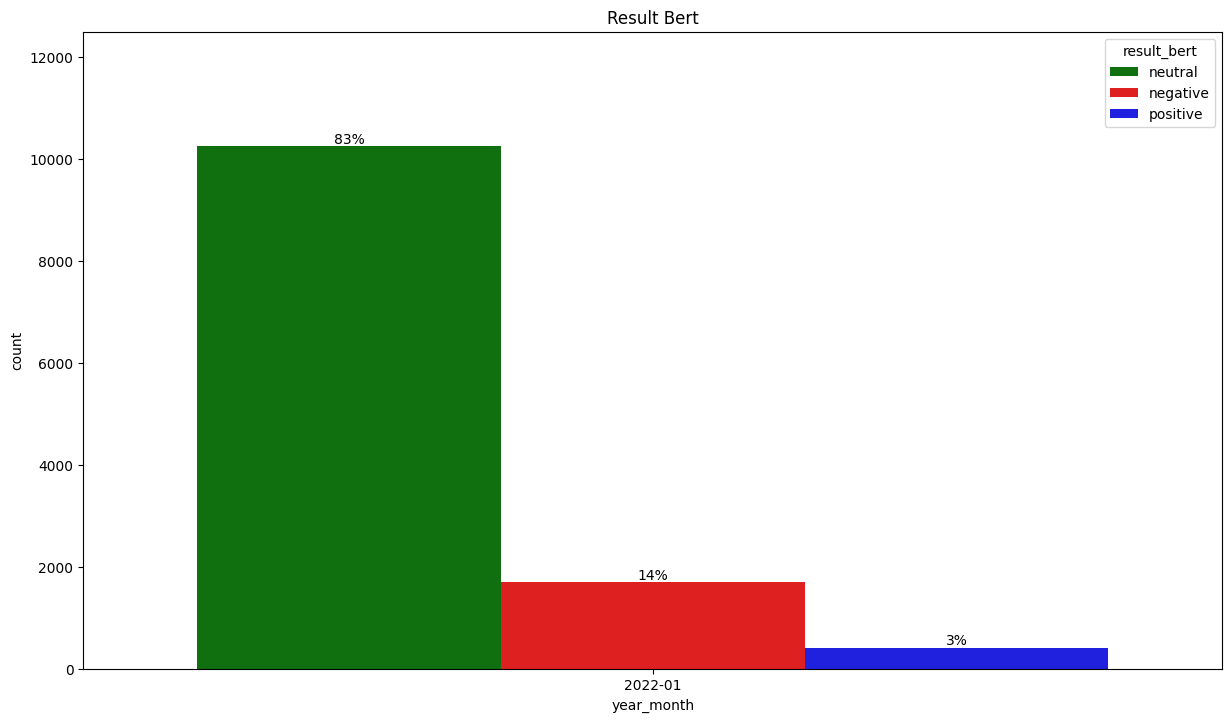

In [58]:
# Define your custom color palette
custom_palette = {
    'positive': 'blue',
    'negative': 'red',
    'neutral': 'green'
}

plt.figure(figsize=[14.70, 8.27])

# Create a count plot for 'result_bert' with fixed colors
ax1 = sb.countplot(x='year_month', hue='result_bert', data=df_final, palette=custom_palette)
ax1.set_title('Result Bert')

# # Create a count plot for 'result_roberta' with the same fixed colors
# ax2 = sb.countplot(x='year_month', hue='result_roberta', data=df_final, palette=custom_palette)
# ax2.set_title('Result Roberta')

# Call barPerc with the updated axes for both 'result_bert' and 'result_roberta'
barPerc(df_final, 'year_month', ax1)
# barPerc(df_final, 'year_month', ax2)
ax1.set(ylim=(0, 12500))

[(0.0, 12500.0)]

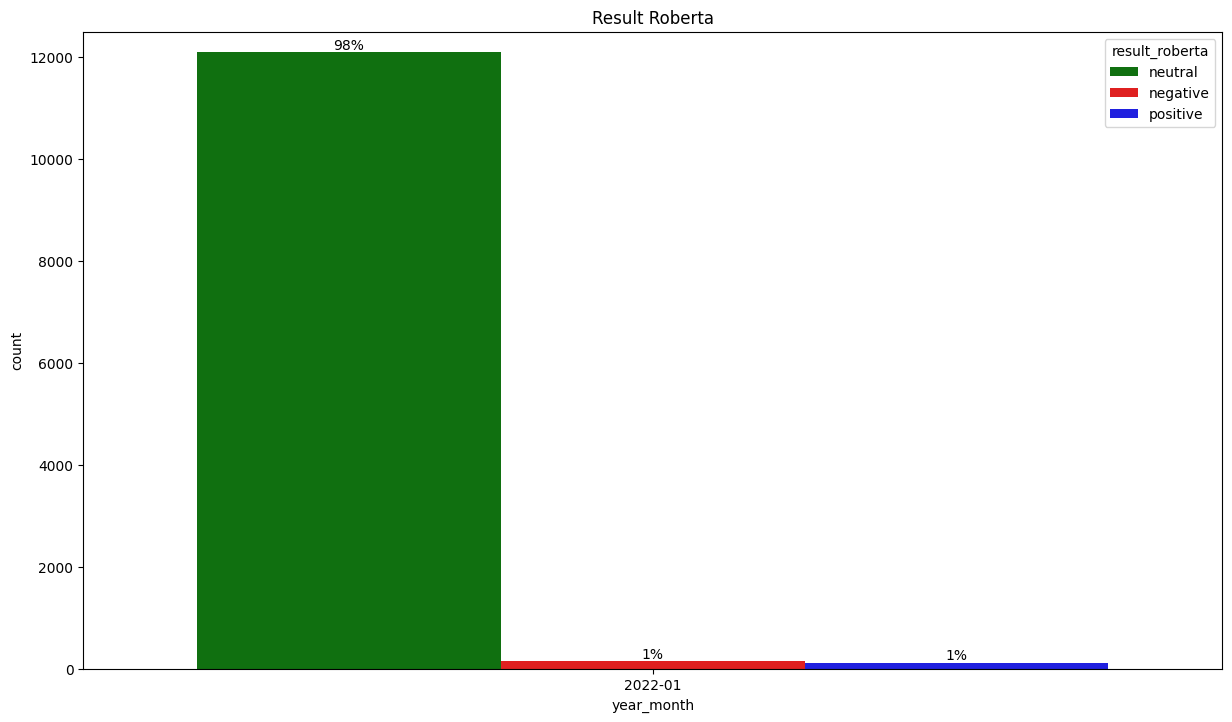

In [59]:
# Define your custom color palette
custom_palette = {
    'positive': 'blue',
    'negative': 'red',
    'neutral': 'green'
}

plt.figure(figsize=[14.70, 8.27])

# Create a count plot for 'result_bert' with fixed colors
# ax1 = sb.countplot(x='year_month', hue='result_bert', data=df_final, palette=custom_palette)
# ax1.set_title('Result Bert')

# # Create a count plot for 'result_roberta' with the same fixed colors
ax2 = sb.countplot(x='year_month', hue='result_roberta', data=df_final, palette=custom_palette)
ax2.set_title('Result Roberta')

# Call barPerc with the updated axes for both 'result_bert' and 'result_roberta'
# barPerc(df_final, 'year_month', ax1)
barPerc(df_final, 'year_month', ax2)
ax2.set(ylim=(0, 12500))

# **Jan-Dec 2021 (Time Frame 1) dataset**

In [88]:
# Define directory path
dir_path = '/content/drive/MyDrive/Data Set/2021_Fri Oct 28/'

# Initialize empty list to store data
data_list = []
df_combined_2021 = pd.DataFrame()

# Loop over all files in directory
for filename in os.listdir(dir_path):
    if filename.endswith('.json'):
        # Read JSON file
        dff = pd.read_json(os.path.join(dir_path, filename))
        df_text = dff[['text', 'created_at']]

        # Apply text cleaning
        df_text['text_cleaned'] = df_text['text'].apply(clean_text)

        # Concatenate cleaned text to the DataFrame
        df_combined_2021 = pd.concat([df_combined_2021, df_text], ignore_index=True)

df_combined_2021.rename(columns={0: 'text'}, inplace=True)
df_combined_2021

<ipython-input-88-007ddbddf9f6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['text_cleaned'] = df_text['text'].apply(clean_text)
<ipython-input-88-007ddbddf9f6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['text_cleaned'] = df_text['text'].apply(clean_text)
<ipython-input-88-007ddbddf9f6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

,text,created_at,text_cleaned
0,RT @Modelamong: Erstaunlich: Börse vor Acht wa...,2021-03-06 08:42:55+00:00,modelamong erstaunlich börse acht heute fast k...
1,"RT @NaturFreunde: Dass die #AKW-Betreiber 2,42...",2021-03-06 08:29:51+00:00,naturfreunde akw betreiber milliarden euro ent...
2,wknachrichten | Wie lebt die Region? In unsere...,2021-03-06 08:22:17+00:00,wknachrichten lebt region unserer serie zeigen...
3,"Dass die #AKW-Betreiber 2,428 Milliarden Euro ...",2021-03-06 08:11:41+00:00,akw betreiber milliarden euro entschädigung at...
4,This! ☝👇🏾 #Atomkraft \nUnd die staatlich geför...,2021-03-06 07:45:17+00:00,this atomkraft staatlich geförderte kultur pan...
...,...,...,...
33287,Nerds Männer Bio-T-Shirt https://t.co/iBwCwdky...,2021-03-12 06:24:44+00:00,nerd männer bio shirt via pinterest nerd nerd ...
33288,RT @Oliver_Krischer: #Fukushima und #Tschernob...,2021-03-12 06:23:40+00:00,oliver krischer fukushima tschernobyl schlimms...
33289,RT @ABaerbock: 10 Jahre #Fukushima - Zeit inne...,2021-03-12 06:21:03+00:00,abaerbock jahre fukushima zeit innezuhalten vi...
33290,Das Risiko von Energie aus #Atomkraft kann kei...,2021-03-12 06:17:33+00:00,risiko energie atomkraft verantworten fukushim...


In [89]:
df_combined_2021

,text,created_at,text_cleaned
0,RT @Modelamong: Erstaunlich: Börse vor Acht wa...,2021-03-06 08:42:55+00:00,modelamong erstaunlich börse acht heute fast k...
1,"RT @NaturFreunde: Dass die #AKW-Betreiber 2,42...",2021-03-06 08:29:51+00:00,naturfreunde akw betreiber milliarden euro ent...
2,wknachrichten | Wie lebt die Region? In unsere...,2021-03-06 08:22:17+00:00,wknachrichten lebt region unserer serie zeigen...
3,"Dass die #AKW-Betreiber 2,428 Milliarden Euro ...",2021-03-06 08:11:41+00:00,akw betreiber milliarden euro entschädigung at...
4,This! ☝👇🏾 #Atomkraft \nUnd die staatlich geför...,2021-03-06 07:45:17+00:00,this atomkraft staatlich geförderte kultur pan...
...,...,...,...
33287,Nerds Männer Bio-T-Shirt https://t.co/iBwCwdky...,2021-03-12 06:24:44+00:00,nerd männer bio shirt via pinterest nerd nerd ...
33288,RT @Oliver_Krischer: #Fukushima und #Tschernob...,2021-03-12 06:23:40+00:00,oliver krischer fukushima tschernobyl schlimms...
33289,RT @ABaerbock: 10 Jahre #Fukushima - Zeit inne...,2021-03-12 06:21:03+00:00,abaerbock jahre fukushima zeit innezuhalten vi...
33290,Das Risiko von Energie aus #Atomkraft kann kei...,2021-03-12 06:17:33+00:00,risiko energie atomkraft verantworten fukushim...


In [90]:
df_combined_2021['created_at'] = pd.to_datetime(df_combined_2021['created_at'])

# Extract just the date portion
df_combined_2021['created_at'] = pd.to_datetime(df_combined_2021['created_at']).dt.date

df_combined_2021['year_month'] = pd.to_datetime(df_combined_2021['created_at']).dt.strftime('%Y-%m')
df_combined_2021

,text,created_at,text_cleaned,year_month
0,RT @Modelamong: Erstaunlich: Börse vor Acht wa...,2021-03-06,modelamong erstaunlich börse acht heute fast k...,2021-03
1,"RT @NaturFreunde: Dass die #AKW-Betreiber 2,42...",2021-03-06,naturfreunde akw betreiber milliarden euro ent...,2021-03
2,wknachrichten | Wie lebt die Region? In unsere...,2021-03-06,wknachrichten lebt region unserer serie zeigen...,2021-03
3,"Dass die #AKW-Betreiber 2,428 Milliarden Euro ...",2021-03-06,akw betreiber milliarden euro entschädigung at...,2021-03
4,This! ☝👇🏾 #Atomkraft \nUnd die staatlich geför...,2021-03-06,this atomkraft staatlich geförderte kultur pan...,2021-03
...,...,...,...,...
33287,Nerds Männer Bio-T-Shirt https://t.co/iBwCwdky...,2021-03-12,nerd männer bio shirt via pinterest nerd nerd ...,2021-03
33288,RT @Oliver_Krischer: #Fukushima und #Tschernob...,2021-03-12,oliver krischer fukushima tschernobyl schlimms...,2021-03
33289,RT @ABaerbock: 10 Jahre #Fukushima - Zeit inne...,2021-03-12,abaerbock jahre fukushima zeit innezuhalten vi...,2021-03
33290,Das Risiko von Energie aus #Atomkraft kann kei...,2021-03-12,risiko energie atomkraft verantworten fukushim...,2021-03


In [92]:
df_jan_2021 = df_combined_2021[df_combined_2021['year_month'] == '2021-01'].reset_index(drop=True)

In [93]:
df_jan_2021

,text,created_at,text_cleaned,year_month
0,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-09,honkhase kriti sektor energie trotz rissen rea...,2021-01
1,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-08,honkhase kriti sektor energie trotz rissen rea...,2021-01
2,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-08,honkhase kriti sektor energie trotz rissen rea...,2021-01
3,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-08,honkhase kriti sektor energie trotz rissen rea...,2021-01
4,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-08,honkhase kriti sektor energie trotz rissen rea...,2021-01
...,...,...,...,...
1043,RT @bund_nrw: Wir haben Widerspruch gegen den ...,2021-01-09,bund nrw widerspruch geplanten export urandiox...,2021-01
1044,RT @bund_nrw: Wir haben Widerspruch gegen den ...,2021-01-09,bund nrw widerspruch geplanten export urandiox...,2021-01
1045,@ausgestrahlt Störfälle in D seit 2000: 3.\nIm...,2021-01-09,ausgestrahlt störfälle seit jahr jahr sicher s...,2021-01
1046,RT @urantransport: #Antiatom Bündnis AgiEL sol...,2021-01-09,urantransport antiatom bündnis agiel solidaris...,2021-01


# **2021 Jan BERT Results**

In [99]:
model = SentimentModel()
texts = df_jan_2021['text_cleaned']
result_bert = model.predict_sentiment(texts)

In [100]:

df_jan_2021['result_bert'] = result_bert
df_jan_2021

,text,created_at,text_cleaned,year_month,result_bert
0,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-09,honkhase kriti sektor energie trotz rissen rea...,2021-01,neutral
1,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-08,honkhase kriti sektor energie trotz rissen rea...,2021-01,neutral
2,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-08,honkhase kriti sektor energie trotz rissen rea...,2021-01,neutral
3,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-08,honkhase kriti sektor energie trotz rissen rea...,2021-01,neutral
4,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-08,honkhase kriti sektor energie trotz rissen rea...,2021-01,neutral
...,...,...,...,...,...
1043,RT @bund_nrw: Wir haben Widerspruch gegen den ...,2021-01-09,bund nrw widerspruch geplanten export urandiox...,2021-01,neutral
1044,RT @bund_nrw: Wir haben Widerspruch gegen den ...,2021-01-09,bund nrw widerspruch geplanten export urandiox...,2021-01,neutral
1045,@ausgestrahlt Störfälle in D seit 2000: 3.\nIm...,2021-01-09,ausgestrahlt störfälle seit jahr jahr sicher s...,2021-01,negative
1046,RT @urantransport: #Antiatom Bündnis AgiEL sol...,2021-01-09,urantransport antiatom bündnis agiel solidaris...,2021-01,neutral


# **2021 Jan xlm-Roberta Results**

In [96]:
model_path = "citizenlab/twitter-xlm-roberta-base-sentiment-finetunned"

sentiment_classifier = pipeline("text-classification", model=model_path, tokenizer=model_path)
result_roberta =[]
for l in df_jan_2021['text_cleaned']:
  result_roberta.append(sentiment_classifier(l))

result_roberta

[[{'label': 'Neutral', 'score': 0.9914679527282715}],
 [{'label': 'Neutral', 'score': 0.9914679527282715}],
 [{'label': 'Neutral', 'score': 0.9914679527282715}],
 [{'label': 'Neutral', 'score': 0.9914679527282715}],
 [{'label': 'Neutral', 'score': 0.9914679527282715}],
 [{'label': 'Neutral', 'score': 0.9896450042724609}],
 [{'label': 'Neutral', 'score': 0.9902909398078918}],
 [{'label': 'Neutral', 'score': 0.9878383874893188}],
 [{'label': 'Neutral', 'score': 0.9817967414855957}],
 [{'label': 'Neutral', 'score': 0.9817967414855957}],
 [{'label': 'Neutral', 'score': 0.9914239048957825}],
 [{'label': 'Neutral', 'score': 0.9902909398078918}],
 [{'label': 'Neutral', 'score': 0.9902909398078918}],
 [{'label': 'Neutral', 'score': 0.9914239048957825}],
 [{'label': 'Neutral', 'score': 0.9902909398078918}],
 [{'label': 'Neutral', 'score': 0.9817967414855957}],
 [{'label': 'Neutral', 'score': 0.9913731217384338}],
 [{'label': 'Neutral', 'score': 0.990871250629425}],
 [{'label': 'Neutral', 'score

In [101]:
labels_sent = [d['label'] for lst2 in result_roberta for d in lst2]
df_senti_model=pd.DataFrame(labels_sent)
df_senti_model = df_senti_model[0].str.lower()
df_senti_model


0       neutral
1       neutral
2       neutral
3       neutral
4       neutral
         ...   
1043    neutral
1044    neutral
1045    neutral
1046    neutral
1047    neutral
Name: 0, Length: 1048, dtype: object

In [102]:
df_jan_2021['result_roberta'] =df_senti_model
df_jan_2021

,text,created_at,text_cleaned,year_month,result_bert,result_roberta
0,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-09,honkhase kriti sektor energie trotz rissen rea...,2021-01,neutral,neutral
1,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-08,honkhase kriti sektor energie trotz rissen rea...,2021-01,neutral,neutral
2,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-08,honkhase kriti sektor energie trotz rissen rea...,2021-01,neutral,neutral
3,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-08,honkhase kriti sektor energie trotz rissen rea...,2021-01,neutral,neutral
4,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-08,honkhase kriti sektor energie trotz rissen rea...,2021-01,neutral,neutral
...,...,...,...,...,...,...
1043,RT @bund_nrw: Wir haben Widerspruch gegen den ...,2021-01-09,bund nrw widerspruch geplanten export urandiox...,2021-01,neutral,neutral
1044,RT @bund_nrw: Wir haben Widerspruch gegen den ...,2021-01-09,bund nrw widerspruch geplanten export urandiox...,2021-01,neutral,neutral
1045,@ausgestrahlt Störfälle in D seit 2000: 3.\nIm...,2021-01-09,ausgestrahlt störfälle seit jahr jahr sicher s...,2021-01,negative,neutral
1046,RT @urantransport: #Antiatom Bündnis AgiEL sol...,2021-01-09,urantransport antiatom bündnis agiel solidaris...,2021-01,neutral,neutral


In [103]:
word_length_list =[]
for item in df_jan_2021['text_cleaned']:
  words = item.split()
  word_length_list.append(len(words))
df_jan_2021['Lenght of cleaned_text'] = word_length_list
df_jan_2021

,text,created_at,text_cleaned,year_month,result_bert,result_roberta,Lenght of cleaned_text
0,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-09,honkhase kriti sektor energie trotz rissen rea...,2021-01,neutral,neutral,14
1,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-08,honkhase kriti sektor energie trotz rissen rea...,2021-01,neutral,neutral,14
2,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-08,honkhase kriti sektor energie trotz rissen rea...,2021-01,neutral,neutral,14
3,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-08,honkhase kriti sektor energie trotz rissen rea...,2021-01,neutral,neutral,14
4,RT @HonkHase: #KRITIS Sektor #Energie\n\nTrotz...,2021-01-08,honkhase kriti sektor energie trotz rissen rea...,2021-01,neutral,neutral,14
...,...,...,...,...,...,...,...
1043,RT @bund_nrw: Wir haben Widerspruch gegen den ...,2021-01-09,bund nrw widerspruch geplanten export urandiox...,2021-01,neutral,neutral,11
1044,RT @bund_nrw: Wir haben Widerspruch gegen den ...,2021-01-09,bund nrw widerspruch geplanten export urandiox...,2021-01,neutral,neutral,11
1045,@ausgestrahlt Störfälle in D seit 2000: 3.\nIm...,2021-01-09,ausgestrahlt störfälle seit jahr jahr sicher s...,2021-01,negative,neutral,11
1046,RT @urantransport: #Antiatom Bündnis AgiEL sol...,2021-01-09,urantransport antiatom bündnis agiel solidaris...,2021-01,neutral,neutral,12


In [104]:
df_jan_2021['Lenght of cleaned_text'].mean()

13.27767175572519

In [105]:
df_jan_2021.to_csv("/content/drive/MyDrive/Derived_data/bert_roberta_jan_2021.csv")

In [106]:
jan_2021=pd.read_csv("/content/drive/MyDrive/Derived_data/bert_roberta_jan_2021.csv")

In [5]:
# read jan data
jan_2021_df = pd.read_csv("/content/drive/MyDrive/Derived_data/bert_roberta_jan_2021.csv")
jan_2023_df = pd.read_csv("/content/drive/MyDrive/Derived_data/bert_roberta_2023.csv")
jan_2022_df = pd.read_csv("/content/drive/MyDrive/Derived_data/bert_roberta_jan_2022.csv",lineterminator='\n')

In [6]:
percentage_dict = {}
# If you specifically want the count for a specific value (e.g., 'specific_value')
count_of_negative_2021 = jan_2021_df['result_bert'].value_counts()['negative']

percentage_2021 = (count_of_negative_2021/len(jan_2021_df)) * 100
percentage_dict["january 2021"] = round(percentage_2021,2)
percentage_dict

{'january 2021': 19.18}

In [7]:
count_of_negative_2022 = jan_2022_df['result_bert'].value_counts()['negative']

percentage_2022 = (count_of_negative_2022/len(jan_2022_df)) * 100
percentage_dict["january 2022"] = round(percentage_2022,2)
percentage_dict

{'january 2021': 19.18, 'january 2022': 13.7}

In [8]:
count_of_negative_2023 = jan_2023_df['result_bert'].value_counts()['negative']
percentage_2023 = (count_of_negative_2023/len(jan_2023_df)) * 100
percentage_dict["january 2023"] = round(percentage_2023,2)
percentage_dict

{'january 2021': 19.18, 'january 2022': 13.7, 'january 2023': 41.38}

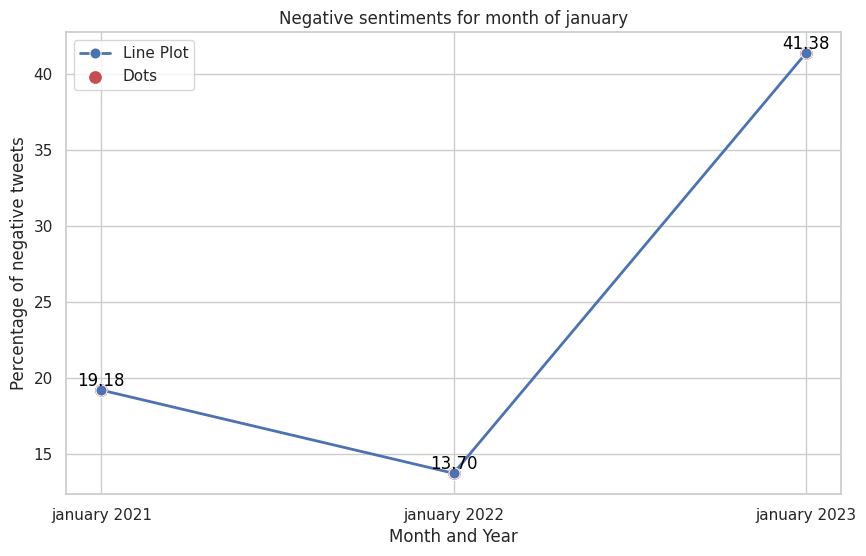

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
data = percentage_dict

# Extract keys and values from the data dictionary
months = list(data.keys())
values = list(data.values())

# Plotting with seaborn
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')

# Scatter plot with line
scatter = sns.lineplot(x=months, y=values, marker='o', color='b', linewidth=2, markersize=8, label='Line Plot')
scatter = sns.scatterplot(x=months, y=values, color='r', s=100, label='Dots')

# Adding x, y values on each dot
for line in range(0, len(months)):
    scatter.text(months[line], values[line], f'{values[line]:.2f}', color='black', ha='center', va='bottom')

# Adding labels and title
plt.xlabel('Month and Year')
plt.ylabel('Percentage of negative tweets')
plt.title('Negative sentiments for month of january')

# Show the plot
plt.show()


# **Jan-Dec 2021 (Time Frame 1) BERT Results**

In [ ]:
model = SentimentModel()
texts = df_combined['text_cleaned'].iloc[0:2000]
result1 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[2000:4000]
result2 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[4000:6000]
result3 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[6000:8000]
result4 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[8000:9000]
result5 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[9000:9500]
result6 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[9500:10000]
result7 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[10000:11000]
result8 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[11000:13000]
result9 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[13000:15000]
result10 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[15000:17000]
result11 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[17000:19000]
result12 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[19000:21000]
result13 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[21000:23000]
result14 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[23000:24000]
result15 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[24000:25000]
result16 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[25000:25500]
result17 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[25500:26000]
result18 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[26000:27000]
result19 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[27000:27500]
result20 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[27500:28000]
result21 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[28000:29000]
result22 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[29000:30000]
result23 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[30000:31000]
result24 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[31000:32000]
result25 = model.predict_sentiment(texts)

In [ ]:
texts = df_combined['text_cleaned'].iloc[32000:]
result26 = model.predict_sentiment(texts)

In [ ]:
result_bert=result1+result2+result3+result4+result5+result6+result7+result8+result9+result10+result11+result12+result13+result14+result15+result16+result17+result18+result19+result20+result21+result22+result23+result24+result25+result26


In [ ]:
df_final = df_combined
df_final['result_bert'] = result_bert
df_final


,text,created_at,text_cleaned,result_bert
0,RT @Modelamong: Erstaunlich: Börse vor Acht wa...,2021-03-06 08:42:55+00:00,modelamong erstaunlich börse acht heute fast k...,neutral
1,"RT @NaturFreunde: Dass die #AKW-Betreiber 2,42...",2021-03-06 08:29:51+00:00,naturfreunde akw betreiber milliarden euro ent...,neutral
2,wknachrichten | Wie lebt die Region? In unsere...,2021-03-06 08:22:17+00:00,wknachrichten lebt region unserer serie zeigen...,neutral
3,"Dass die #AKW-Betreiber 2,428 Milliarden Euro ...",2021-03-06 08:11:41+00:00,akw betreiber milliarden euro entschädigung at...,neutral
4,This! ☝👇🏾 #Atomkraft \nUnd die staatlich geför...,2021-03-06 07:45:17+00:00,this atomkraft staatlich geförderte kultur pan...,neutral
...,...,...,...,...
33287,Nerds Männer Bio-T-Shirt https://t.co/iBwCwdky...,2021-03-12 06:24:44+00:00,nerd männer bio shirt via pinterest nerd nerd ...,negative
33288,RT @Oliver_Krischer: #Fukushima und #Tschernob...,2021-03-12 06:23:40+00:00,oliver krischer fukushima tschernobyl schlimms...,negative
33289,RT @ABaerbock: 10 Jahre #Fukushima - Zeit inne...,2021-03-12 06:21:03+00:00,abaerbock jahre fukushima zeit innezuhalten vi...,neutral
33290,Das Risiko von Energie aus #Atomkraft kann kei...,2021-03-12 06:17:33+00:00,risiko energie atomkraft verantworten fukushim...,neutral


In [ ]:
df_final['created_at'] = pd.to_datetime(df_final['created_at'])

# Extract just the date portion
df_final['created_at'] = pd.to_datetime(df_final['created_at']).dt.date

df_final['year_month'] = pd.to_datetime(df_final['created_at']).dt.strftime('%Y-%m')
df_final

,text,created_at,text_cleaned,result_bert,year_month
0,RT @Modelamong: Erstaunlich: Börse vor Acht wa...,2021-03-06,modelamong erstaunlich börse acht heute fast k...,neutral,2021-03
1,"RT @NaturFreunde: Dass die #AKW-Betreiber 2,42...",2021-03-06,naturfreunde akw betreiber milliarden euro ent...,neutral,2021-03
2,wknachrichten | Wie lebt die Region? In unsere...,2021-03-06,wknachrichten lebt region unserer serie zeigen...,neutral,2021-03
3,"Dass die #AKW-Betreiber 2,428 Milliarden Euro ...",2021-03-06,akw betreiber milliarden euro entschädigung at...,neutral,2021-03
4,This! ☝👇🏾 #Atomkraft \nUnd die staatlich geför...,2021-03-06,this atomkraft staatlich geförderte kultur pan...,neutral,2021-03
...,...,...,...,...,...
33287,Nerds Männer Bio-T-Shirt https://t.co/iBwCwdky...,2021-03-12,nerd männer bio shirt via pinterest nerd nerd ...,negative,2021-03
33288,RT @Oliver_Krischer: #Fukushima und #Tschernob...,2021-03-12,oliver krischer fukushima tschernobyl schlimms...,negative,2021-03
33289,RT @ABaerbock: 10 Jahre #Fukushima - Zeit inne...,2021-03-12,abaerbock jahre fukushima zeit innezuhalten vi...,neutral,2021-03
33290,Das Risiko von Energie aus #Atomkraft kann kei...,2021-03-12,risiko energie atomkraft verantworten fukushim...,neutral,2021-03


In [ ]:
def barPerc(df,xVar,ax):
    '''
    barPerc(): Add percentage for hues to bar plots
    args:
        df: pandas dataframe
        xVar: (string) X variable
        ax: Axes object (for Seaborn Countplot/Bar plot or
                         pandas bar plot)
    '''
    # 1. how many X categories
    ##   check for NaN and remove
    numX=len([x for x in df[xVar].unique() if x==x])

    # 2. The bars are created in hue order, organize them
    bars = ax.patches
    ## 2a. For each X variable
    for ind in range(numX):
        ## 2b. Get every hue bar
        ##     ex. 8 X categories, 4 hues =>
        ##    [0, 8, 16, 24] are hue bars for 1st X category
        hueBars=bars[ind:][::numX]
        ## 2c. Get the total height (for percentages)
        total = sum([x.get_height() for x in hueBars])

        # 3. Print the percentage on the bars
        for bar in hueBars:
            ax.text(bar.get_x() + bar.get_width()/2.,
                    bar.get_height(),
                    f'{bar.get_height()/total:.0%}',
                    ha="center",va="bottom")

[(0.0, 6000.0)]

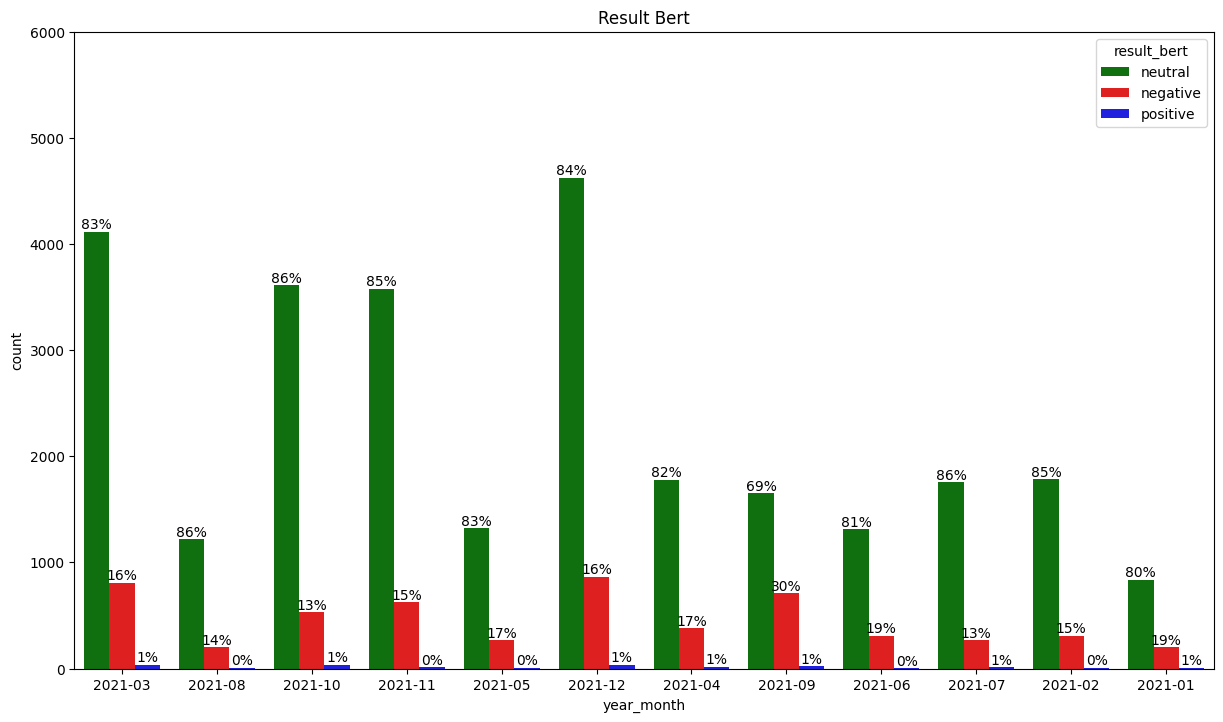

In [ ]:
# Define your custom color palette
custom_palette = {
    'positive': 'blue',
    'negative': 'red',
    'neutral': 'green'
}

plt.figure(figsize=[14.70, 8.27])

# Create a count plot for 'result_bert' with fixed colors
ax1 = sb.countplot(x='year_month', hue='result_bert', data=df_final, palette=custom_palette)
ax1.set_title('Result Bert')

# # Create a count plot for 'result_roberta' with the same fixed colors
# ax2 = sb.countplot(x='year_month', hue='result_roberta', data=df_final, palette=custom_palette)
# ax2.set_title('Result Roberta')

# Call barPerc with the updated axes for both 'result_bert' and 'result_roberta'
barPerc(df_final, 'year_month', ax1)
# barPerc(df_final, 'year_month', ax2)
ax1.set(ylim=(0, 6000))

# **Jan-Dec 2021 (Time Frame 1) xlm-Roberta Results**

In [ ]:
model_path = "citizenlab/twitter-xlm-roberta-base-sentiment-finetunned"

sentiment_classifier = pipeline("text-classification", model=model_path, tokenizer=model_path)
result1 =[]
for l in df_combined['text_cleaned'].iloc[0:2000]:
  result1.append(sentiment_classifier(l))

result1

In [ ]:
result2 =[]
for l in df_combined['text_cleaned'].iloc[2000:4000]:
  result2.append(sentiment_classifier(l))

result2

In [ ]:
result3 =[]
for l in df_combined['text_cleaned'].iloc[4000:6000]:
  result3.append(sentiment_classifier(l))

result3

In [ ]:

result4 =[]
for l in df_combined['text_cleaned'].iloc[6000:8000]:
  result4.append(sentiment_classifier(l))

result4

In [ ]:
result5 =[]
for l in df_combined['text_cleaned'].iloc[8000:10000]:
  result5.append(sentiment_classifier(l))

result5

In [ ]:
result6 =[]
for l in df_combined['text_cleaned'].iloc[10000:12000]:
  result6.append(sentiment_classifier(l))

result6


In [ ]:
result7 =[]
for l in df_combined['text_cleaned'].iloc[12000:14000]:
  result7.append(sentiment_classifier(l))

result7

In [ ]:
result8=[]
for l in df_combined['text_cleaned'].iloc[14000:16000]:
  result8.append(sentiment_classifier(l))

result8

In [ ]:
result9=[]
for l in df_combined['text_cleaned'].iloc[16000:18000]:
  result9.append(sentiment_classifier(l))

result9

In [ ]:
result10=[]
for l in df_combined['text_cleaned'].iloc[18000:20000]:
  result10.append(sentiment_classifier(l))

result10

In [ ]:
result11=[]
for l in df_combined['text_cleaned'].iloc[20000:22000]:
  result11.append(sentiment_classifier(l))

result11

In [ ]:
result12=[]
for l in df_combined['text_cleaned'].iloc[22000:24000]:
  result12.append(sentiment_classifier(l))

result12

In [ ]:
result13=[]
for l in df_combined['text_cleaned'].iloc[24000:26000]:
  result13.append(sentiment_classifier(l))

result13

In [ ]:
result14=[]
for l in df_combined['text_cleaned'].iloc[26000:28000]:
  result14.append(sentiment_classifier(l))

result14

In [ ]:
result15=[]
for l in df_combined['text_cleaned'].iloc[28000:30000]:
  result15.append(sentiment_classifier(l))

result15

In [ ]:
result16=[]
for l in df_combined['text_cleaned'].iloc[30000:32000]:
  result16.append(sentiment_classifier(l))

result16

In [ ]:
result17=[]
for l in df_combined['text_cleaned'].iloc[32000:]:
  result17.append(sentiment_classifier(l))

result17

In [ ]:
result_roberta=result1+result2+result3+result4+result5+result6+result7+result8+result9+result10+result11+result12+result13+result14+result15+result16+result17


In [ ]:
labels_sent = [d['label'] for lst2 in result_roberta for d in lst2]
df_senti_model=pd.DataFrame(labels_sent)
df_senti_model = df_senti_model[0].str.lower()
df_senti_model

0        neutral
1        neutral
2        neutral
3        neutral
4        neutral
          ...   
33287    neutral
33288    neutral
33289    neutral
33290    neutral
33291    neutral
Name: 0, Length: 33292, dtype: object

In [ ]:
df_final = df_combined
df_final['result_roberta'] =df_senti_model
df_final

,text,created_at,text_cleaned,result_roberta
0,RT @Modelamong: Erstaunlich: Börse vor Acht wa...,2021-03-06 08:42:55+00:00,modelamong erstaunlich börse acht heute fast k...,neutral
1,"RT @NaturFreunde: Dass die #AKW-Betreiber 2,42...",2021-03-06 08:29:51+00:00,naturfreunde akw betreiber milliarden euro ent...,neutral
2,wknachrichten | Wie lebt die Region? In unsere...,2021-03-06 08:22:17+00:00,wknachrichten lebt region unserer serie zeigen...,neutral
3,"Dass die #AKW-Betreiber 2,428 Milliarden Euro ...",2021-03-06 08:11:41+00:00,akw betreiber milliarden euro entschädigung at...,neutral
4,This! ☝👇🏾 #Atomkraft \nUnd die staatlich geför...,2021-03-06 07:45:17+00:00,this atomkraft staatlich geförderte kultur pan...,neutral
...,...,...,...,...
33287,Nerds Männer Bio-T-Shirt https://t.co/iBwCwdky...,2021-03-12 06:24:44+00:00,nerd männer bio shirt via pinterest nerd nerd ...,neutral
33288,RT @Oliver_Krischer: #Fukushima und #Tschernob...,2021-03-12 06:23:40+00:00,oliver krischer fukushima tschernobyl schlimms...,neutral
33289,RT @ABaerbock: 10 Jahre #Fukushima - Zeit inne...,2021-03-12 06:21:03+00:00,abaerbock jahre fukushima zeit innezuhalten vi...,neutral
33290,Das Risiko von Energie aus #Atomkraft kann kei...,2021-03-12 06:17:33+00:00,risiko energie atomkraft verantworten fukushim...,neutral


In [ ]:
df_final['created_at'] = pd.to_datetime(df_final['created_at'])

# Extract just the date portion
df_final['created_at'] = pd.to_datetime(df_final['created_at']).dt.date

df_final['year_month'] = pd.to_datetime(df_final['created_at']).dt.strftime('%Y-%m')
df_final

,text,created_at,text_cleaned,result_roberta,year_month
0,RT @Modelamong: Erstaunlich: Börse vor Acht wa...,2021-03-06,modelamong erstaunlich börse acht heute fast k...,neutral,2021-03
1,"RT @NaturFreunde: Dass die #AKW-Betreiber 2,42...",2021-03-06,naturfreunde akw betreiber milliarden euro ent...,neutral,2021-03
2,wknachrichten | Wie lebt die Region? In unsere...,2021-03-06,wknachrichten lebt region unserer serie zeigen...,neutral,2021-03
3,"Dass die #AKW-Betreiber 2,428 Milliarden Euro ...",2021-03-06,akw betreiber milliarden euro entschädigung at...,neutral,2021-03
4,This! ☝👇🏾 #Atomkraft \nUnd die staatlich geför...,2021-03-06,this atomkraft staatlich geförderte kultur pan...,neutral,2021-03
...,...,...,...,...,...
33287,Nerds Männer Bio-T-Shirt https://t.co/iBwCwdky...,2021-03-12,nerd männer bio shirt via pinterest nerd nerd ...,neutral,2021-03
33288,RT @Oliver_Krischer: #Fukushima und #Tschernob...,2021-03-12,oliver krischer fukushima tschernobyl schlimms...,neutral,2021-03
33289,RT @ABaerbock: 10 Jahre #Fukushima - Zeit inne...,2021-03-12,abaerbock jahre fukushima zeit innezuhalten vi...,neutral,2021-03
33290,Das Risiko von Energie aus #Atomkraft kann kei...,2021-03-12,risiko energie atomkraft verantworten fukushim...,neutral,2021-03


In [ ]:
def barPerc(df,xVar,ax):
    '''
    barPerc(): Add percentage for hues to bar plots
    args:
        df: pandas dataframe
        xVar: (string) X variable
        ax: Axes object (for Seaborn Countplot/Bar plot or
                         pandas bar plot)
    '''
    # 1. how many X categories
    ##   check for NaN and remove
    numX=len([x for x in df[xVar].unique() if x==x])

    # 2. The bars are created in hue order, organize them
    bars = ax.patches
    ## 2a. For each X variable
    for ind in range(numX):
        ## 2b. Get every hue bar
        ##     ex. 8 X categories, 4 hues =>
        ##    [0, 8, 16, 24] are hue bars for 1st X category
        hueBars=bars[ind:][::numX]
        ## 2c. Get the total height (for percentages)
        total = sum([x.get_height() for x in hueBars])

        # 3. Print the percentage on the bars
        for bar in hueBars:
            ax.text(bar.get_x() + bar.get_width()/2.,
                    bar.get_height(),
                    f'{bar.get_height()/total:.0%}',
                    ha="center",va="bottom")

[(0.0, 6000.0)]

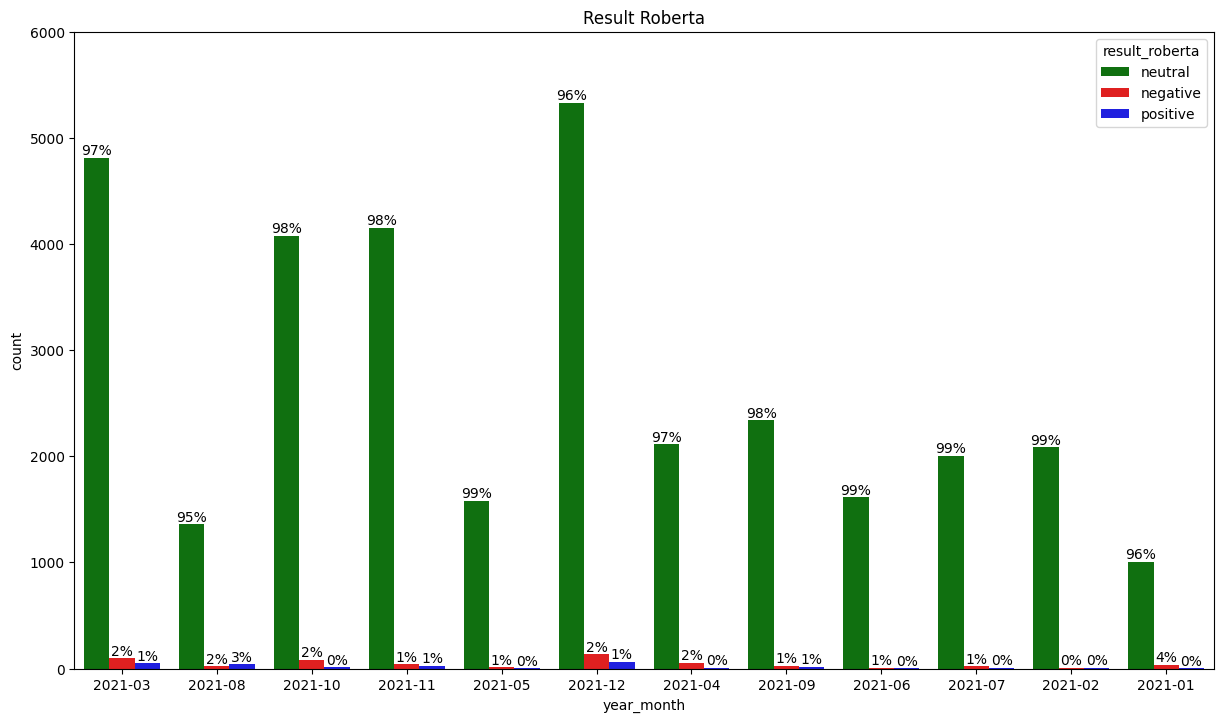

In [ ]:
# Define your custom color palette
custom_palette = {
    'positive': 'blue',
    'negative': 'red',
    'neutral': 'green'
}

plt.figure(figsize=[14.70, 8.27])

# Create a count plot for 'result_bert' with fixed colors
# ax1 = sb.countplot(x='year_month', hue='result_bert', data=df_final, palette=custom_palette)
# ax1.set_title('Result Bert')

# # Create a count plot for 'result_roberta' with the same fixed colors
ax2 = sb.countplot(x='year_month', hue='result_roberta', data=df_final, palette=custom_palette)
ax2.set_title('Result Roberta')

# Call barPerc with the updated axes for both 'result_bert' and 'result_roberta'
# barPerc(df_final, 'year_month', ax1)
barPerc(df_final, 'year_month', ax2)
ax2.set(ylim=(0, 6000))